In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from scipy.special import inv_boxcox

from sklearn.metrics import mean_squared_error
from statsmodels.graphics.gofplots import qqplot

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

### Read the dataset

In [61]:
df = pd.read_excel('Sales_Forecast_Data.xlsx')
df = df[df['COMPANY']=='ABC Manufacturing']
df

,FIN_YEAR,MONTH,STATE,FG,DISTRICT,COMPANY,VALUE
49,2014-2015,Dec,Haryana,Insecticides,Ambala,ABC Manufacturing,6019.380
50,2014-2015,Dec,Haryana,Insecticides,Yamunanagar,ABC Manufacturing,425.250
51,2014-2015,Dec,Haryana,Insecticides,Karnal,ABC Manufacturing,14782.635
52,2014-2015,Dec,Haryana,Insecticides,Panipat,ABC Manufacturing,4031.910
53,2014-2015,Dec,Haryana,Insecticides,Sonipat,ABC Manufacturing,8692.110
...,...,...,...,...,...,...,...
230090,2016-2017,Feb,Punjab,Bactericides,Barnala,ABC Manufacturing,0.000
230144,2016-2017,Dec,Uttar Pradesh,Bactericides,Faizabad,ABC Manufacturing,0.000
230145,2016-2017,Dec,Uttar Pradesh,Bactericides,Basti,ABC Manufacturing,0.000
230146,2016-2017,Dec,Uttar Pradesh,Bactericides,Ballia,ABC Manufacturing,0.000


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28640 entries, 49 to 230147
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FIN_YEAR  28640 non-null  object 
 1   MONTH     28640 non-null  object 
 2   STATE     28640 non-null  object 
 3   FG        28640 non-null  object 
 4   DISTRICT  28640 non-null  object 
 5   COMPANY   28640 non-null  object 
 6   VALUE     28640 non-null  float64
dtypes: float64(1), object(6)
memory usage: 1.7+ MB


In [64]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28640 entries, 49 to 230147
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FIN_YEAR  28640 non-null  object 
 1   MONTH     28640 non-null  object 
 2   STATE     28640 non-null  object 
 3   FG        28640 non-null  object 
 4   DISTRICT  28640 non-null  object 
 5   COMPANY   28640 non-null  object 
 6   VALUE     28640 non-null  float64
dtypes: float64(1), object(6)
memory usage: 11.4 MB


In [3]:
fiscal_firstyear = ['Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
df1 = df[df["MONTH"].isin(fiscal_firstyear)]
df1['Date']= '01-' + df1['MONTH'] + '-' + df1['FIN_YEAR'].str[:4]
df1['Year'] = df1['FIN_YEAR'].str[:4]

In [4]:
fiscal_secondyear = ['Jan','Feb','Mar']
df2 = df[df["MONTH"].isin(fiscal_secondyear)]
df2['Date']= '01-' + df2['MONTH'] + '-' + df2['FIN_YEAR'].str[5:]
df2['Year'] = df2['FIN_YEAR'].str[5:]

In [5]:
df = pd.concat([df1, df2])
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by=['Date'], inplace=True)
df.head()

,FIN_YEAR,MONTH,STATE,FG,DISTRICT,COMPANY,VALUE,Date,Year
119264,2014-2015,Apr,Uttar Pradesh,Rodenticides,Kanpur Dehat,ABC Manufacturing,25.650,2014-04-01,2014
118547,2014-2015,Apr,Uttar Pradesh,Rodenticides,Gautam Buddha Nagar,ABC Manufacturing,0.000,2014-04-01,2014
118546,2014-2015,Apr,Uttar Pradesh,Rodenticides,Ghaziabad,ABC Manufacturing,190.485,2014-04-01,2014
118545,2014-2015,Apr,Uttar Pradesh,Rodenticides,Baghpat,ABC Manufacturing,82.080,2014-04-01,2014
118544,2014-2015,Apr,Uttar Pradesh,Rodenticides,Meerut,ABC Manufacturing,85.995,2014-04-01,2014


### Calculate the monthly sales for each state

In [6]:
df_grouped = df.groupby(['STATE','Date','FIN_YEAR'])['VALUE'].sum().reset_index()
df_grouped['Year'] = df_grouped['Date'].dt.year
df_grouped['Month'] = df_grouped['Date'].dt.month
df_grouped

,STATE,Date,FIN_YEAR,VALUE,Year,Month
0,Haryana,2014-04-01,2014-2015,32577.660,2014,4
1,Haryana,2014-05-01,2014-2015,47482.740,2014,5
2,Haryana,2014-06-01,2014-2015,130684.185,2014,6
3,Haryana,2014-07-01,2014-2015,75471.075,2014,7
4,Haryana,2014-08-01,2014-2015,107146.530,2014,8
...,...,...,...,...,...,...
225,Uttarakhand,2017-09-01,2017-2018,20928.105,2017,9
226,Uttarakhand,2017-10-01,2017-2018,40825.080,2017,10
227,Uttarakhand,2017-11-01,2017-2018,55837.890,2017,11
228,Uttarakhand,2017-12-01,2017-2018,62852.625,2017,12


#### Plot the monthly sales data

<AxesSubplot:xlabel='Date', ylabel='VALUE'>

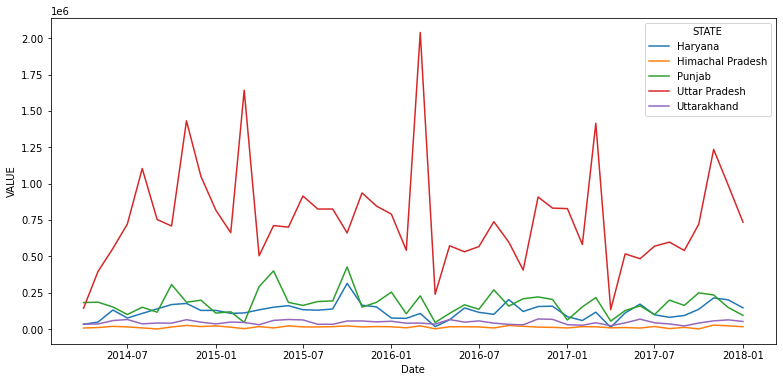

In [7]:
plt.figure(figsize=(13,6))
sns.lineplot(data=df_grouped,x='Date',y='VALUE',hue='STATE', ci=False)

Observations:
Since the time series follows different patterns for different states, lets split the dataset into individual states and perform the analysis/modelling

### Split the dataset into individual states to perform analysis/modelling

In [8]:
df_UP = df_grouped[df_grouped['STATE'] == 'Uttar Pradesh'][['VALUE','Date', 'Year', 'Month']]
df_UP = df_UP.set_index('Date')
df_UP.shape

(46, 3)

In [9]:
df_HR = df_grouped[df_grouped['STATE'] == 'Haryana'][['VALUE','Date', 'Year', 'Month']]
df_HR = df_HR.set_index('Date')
df_HR.shape

(46, 3)

In [10]:
df_HP = df_grouped[df_grouped['STATE'] == 'Himachal Pradesh'][['VALUE','Date', 'Year', 'Month']]
df_HP = df_HP.set_index('Date')
df_HP.shape

(46, 3)

In [11]:
df_UT = df_grouped[df_grouped['STATE'] == 'Uttarakhand'][['VALUE','Date', 'Year', 'Month']]
df_UT = df_UT.set_index('Date')
df_UT.shape

(46, 3)

In [12]:
df_PN = df_grouped[df_grouped['STATE'] == 'Punjab'][['VALUE','Date', 'Year', 'Month']]
df_PN = df_PN.set_index('Date')
df_PN.shape

(46, 3)

Lambda: 0.433100


<AxesSubplot:ylabel='Density'>

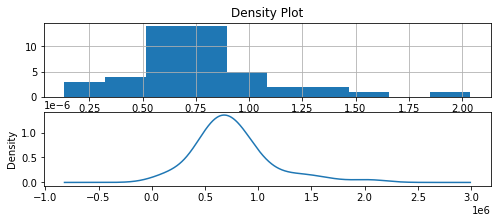

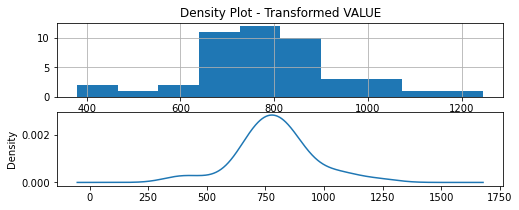

In [15]:
data = df_UP
# Density Plot
plt.figure(figsize=(8,3))
plt.subplot(211)
data['VALUE'].hist()
plt.title('Density Plot')
plt.subplot(212)
data['VALUE'].plot(kind='kde')

# Power Transformation
data['VALUE-Tx'], lam = boxcox(data['VALUE'])
print('Lambda: %f' % lam)

plt.figure(figsize=(8,3))
plt.subplot(211)
data['VALUE-Tx'].hist()
plt.title('Density Plot - Transformed VALUE')
plt.subplot(212)
data['VALUE-Tx'].plot(kind='kde')

#### Utility Functions

In [16]:
def data_analysis(data):
    # Summary Statistics
    display(data.describe())
    print('Mean = %.3f' % data['VALUE'].mean())
    print('Standard Deviation = %.3f' % data['VALUE'].std())
#     print('\n')
    
    # Line Plot
    data['VALUE'].plot(figsize=(13,4))
    plt.title('Line Plot')

    # Seasonal Line Plot
    pivot = data.pivot_table(values='VALUE', index='Month', columns='Year')
    
    plt.figure(figsize=(13,4))
    sns.lineplot(data=pivot)
    plt.title('Seasonal Line Plot')
    
    # Density Plot
    plt.figure(figsize=(13,4))
    plt.subplot(211)
    data['VALUE'].hist()
    plt.title('Density Plot')
    plt.subplot(212)
    data['VALUE'].plot(kind='kde')
    
    # Power Transformation
    data['VALUE-Tx'], lam = boxcox(data['VALUE'])
    print('Lambda: %f' % lam)
    
    plt.figure(figsize=(13,6))
    plt.subplot(211)
    data['VALUE-Tx'].hist()
    plt.title('Density Plot - Transformed VALUE')
    plt.subplot(212)
    data['VALUE-Tx'].plot(kind='kde')

    # Lag Plot
    plt.figure(figsize=(8,4))
    lag_plot(data['VALUE-Tx'])
    plt.title('Lag Plot')
    
    # Autocorrelation Plot
    plt.figure(figsize=(10,4))
    autocorrelation_plot(data['VALUE-Tx'])
    plt.title('Autocorrelation Plot')
    
    return data, lam

In [17]:
def check_whitenoise(data):
    # Check 1: Does it have a zero mean?
    print('Series Mean = %.3f' % data.mean())
    
    # Check 2: Variance changes over time?
    print('2014 Mean = %.3f' % data['2014'].mean())
    print('2015 Mean = %.3f' % data['2015'].mean())
    print('2016 Mean = %.3f' % data['2016'].mean())
    print('2017 Mean = %.3f' % data['2017'].mean())


In [18]:
def check_stationarity(data):
    # Check for Stationarity - Random Walks are non-stationary
    # ADFuller test
    result = adfuller(data)

    print('ADF Statistic %.3f' % result[0])
    print('p-value %f' % result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' %(key, value))

In [19]:
def build_PersistenceModel(data, df_perf, state):
    #Set aside a validation dataset - 12 month data reserved for validation
    split = len(data) - 12
    train, test = data[0:split], data[split:]
    
    # Walk forward validation
    history = [x for x in train]
    predictions = list()
    residuals = list()

    for i in range(len(test)):
        yhat = history[-1]
        predictions.append(yhat)

        obs = test[i]
        error = obs - yhat
        history.append(obs)
        residuals.append(error)
#         print('Predicted=%.3f, Expected=%.3f, Error=%.3f' %(yhat, obs, error))

    residuals = pd.DataFrame(residuals)
    predictions = pd.DataFrame(predictions)
    predictions = predictions.set_index(test.index)

    rmse = np.sqrt(mean_squared_error(test, predictions))
    print('\nRMSE: %.3f' %rmse)
    print('Residual Mean: %.3f' %residuals.mean())
    
    results = [state, 'Persistence Model', '%.3f' %rmse, '%.3f' %residuals.mean()]
    df_perf.loc[len(df_perf)] = results
    
    # Plot the train, test & predictions
    plt.figure(figsize=(12,5))
    plt.figure(1)

    plt.subplot(211)
    plt.plot(train, color='blue')
    plt.plot(test, color = 'green')
    plt.plot(predictions, color='red')
    plt.title('Persistence Model')
    
    plt.subplot(212)
    plt.plot(residuals)
    plt.title('Residual Plot')
    
    # Analyze residuals
    plt.figure(figsize=(8,3))
    residuals.plot(kind='kde', figsize=(8,3))
    plt.title('Distribution - Residual')
    
    # Check the Autocorrelation for the residuals
    plt.figure(figsize=(8,3))
    autocorrelation_plot(residuals)
    plt.title('Autocorrelation - Residual')
    

In [20]:
def build_SES(data,df_perf, state, sm_level):
    split = len(data) - 12
    train, test = data[0:split], data[split:]

    residuals = list()

    y_hat_avg = test.copy()
    fit2 = SimpleExpSmoothing(train).fit(smoothing_level=sm_level,optimized=False)
    y_hat_avg['SES'] = fit2.forecast(len(test))

    residuals = [test[i] - y_hat_avg['SES'][i] for i in range(1,len(test))]
    residuals = pd.DataFrame(residuals)

    rmse = np.sqrt(mean_squared_error(test, y_hat_avg['SES']))
    print('Test RMSE: %.3f' %rmse)
    print('Residual Mean: %.3f' %np.mean(residuals))

    results = [state, 'SES', '%.3f' %rmse, '%.3f' %np.mean(residuals)]
    df_perf.loc[len(df_perf)] = results
    
    plt.figure(figsize=(12,3))
    plt.plot(train, color='blue')
    plt.plot(test, color = 'green')
    plt.plot(y_hat_avg['SES'], color='red')
    plt.legend(loc='best')
    plt.title('Simple Exponential Smoothing')

    plt.figure(figsize=(12,3))
    plt.plot(residuals)
    plt.title('Residual Plot')
    
    # Analyze residuals
    plt.figure(figsize=(8,3))
    residuals.plot(kind='kde', figsize=(8,3))
    plt.title('Distribution - Residual')
    
    # Check the Autocorrelation for the residuals
    plt.figure(figsize=(8,3))
    autocorrelation_plot(residuals)
    plt.title('Autocorrelation - Residual')

In [21]:
def decompose(data):
    rcParams['figure.figsize'] =12,8
    print('Seasonal Decompose')
    result = seasonal_decompose(data)
    fig = result.plot()    

In [22]:
def plot_ACF_PACF(data):
    fig = plt.figure(figsize=(10,6))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(data, ax=ax1)

    ax2 = fig.add_subplot(212)
    fig = plot_pacf(data, ax=ax2)

In [23]:
def build_HoltWinters(data,df_perf,state,trend,seasonal,seasonal_periods,sm_level,sm_slope):
    split = len(data) - 12
    train, test = data[0:split], data[split:]

    residuals = list()

    y_hat_avg = test.copy()
    model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
    model = model.fit(smoothing_level=sm_level, smoothing_slope=sm_slope)

    y_hat_avg['HW'] = model.forecast(len(test))

    residuals = [test[i] - y_hat_avg['HW'][i] for i in range(1,len(test))]
    residuals = pd.DataFrame(residuals)

    rmse = np.sqrt(mean_squared_error(test, y_hat_avg['HW']))
    print('Test RMSE: %.3f' %rmse)
    print('Residual Mean: %.3f' %np.mean(residuals))

    results = [state, 'Holt-Winters', '%.3f' %rmse, '%.3f' %np.mean(residuals)]
    df_perf.loc[len(df_perf)] = results

    plt.figure(figsize=(12,3))
    plt.plot(train, color='blue')
    plt.plot(test, color = 'green')
    plt.plot(y_hat_avg['HW'], color='red')
    plt.legend(loc='best')
    plt.title('Holt-Winters Method')
    
    plt.figure(figsize=(12,3))
    plt.plot(residuals)
    plt.title('Residual Plot')
    
    # Analyze residuals
    plt.figure(figsize=(8,3))
    residuals.plot(kind='kde', figsize=(8,3))
    plt.title('Distribution - Residual')
    
    # Check the Autocorrelation for the residuals
    plt.figure(figsize=(8,3))
    autocorrelation_plot(residuals)
    plt.title('Autocorrelation - Residual')    


In [24]:
def inverse_boxcox_old(data,lam):
    print('Inside inverse_boxcox')
    if lam == 0:
        print('lambda=0')
        return(np.exp(data))
    else:
        print('lambda= %f' %lam )
        return(np.exp(np.log(lam*data+1)/lam))

### Data Analysis - UP

,VALUE,Year,Month,VALUE-Tx
count,4.600000e+01,46.000000,46.000000,46.000000
mean,7.609707e+05,2015.652174,6.673913,790.482766
std,3.591113e+05,1.139540,3.458030,163.652966
min,1.328972e+05,2014.000000,1.000000,379.993982
25%,5.571753e+05,2015.000000,4.000000,708.898779
50%,7.157036e+05,2016.000000,7.000000,790.367196
75%,8.419093e+05,2017.000000,9.750000,848.129022
max,2.039067e+06,2018.000000,12.000000,1245.154685


Mean = 760970.750
Standard Deviation = 359111.325
Lambda: 0.433100


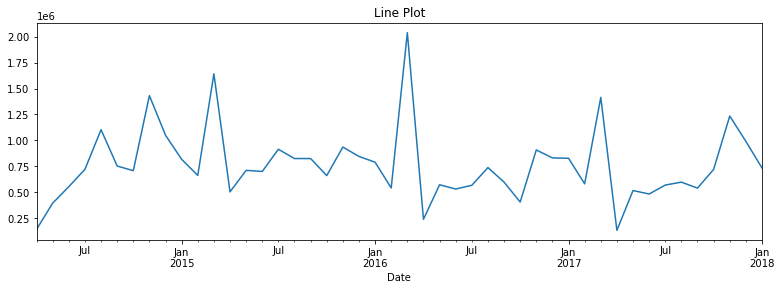

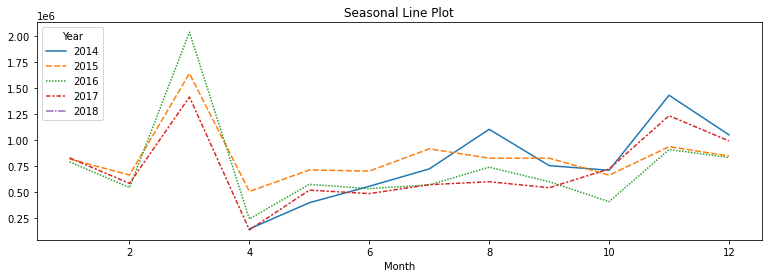

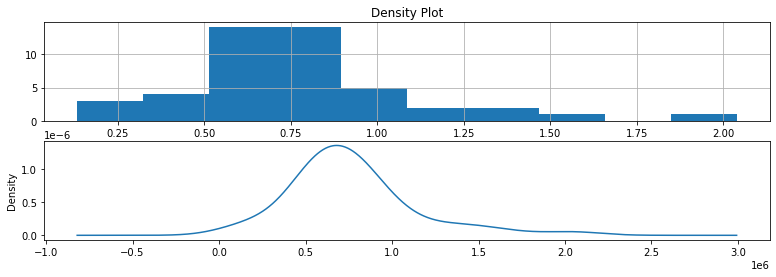

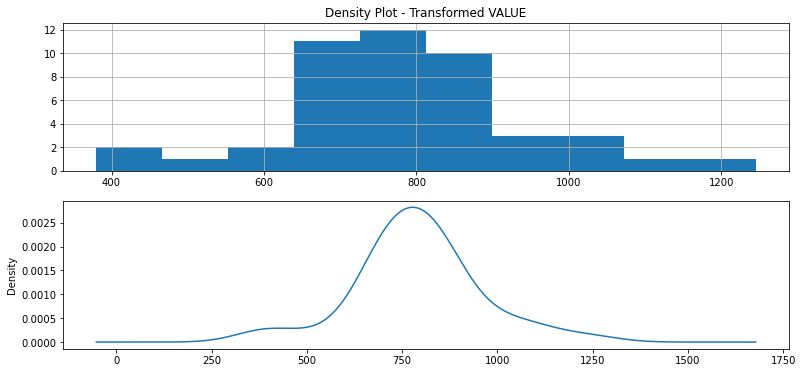

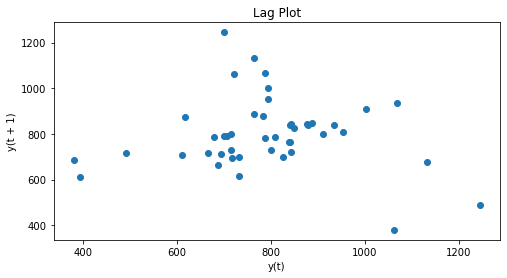

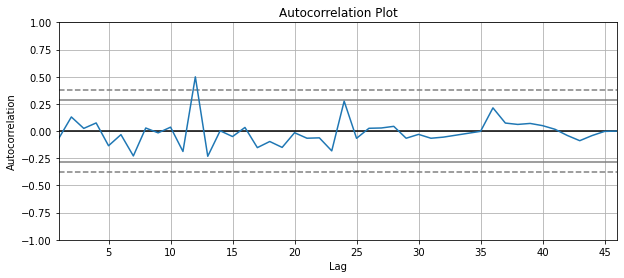

In [25]:
df_UP, lamda = data_analysis(df_UP)

Observations from the summary statistics:
1. The number is observations = 46 (as expected)
2. The mean is about 760970.750, which we will consider our level in this series
3. The standard deviation (avg spread from the mean) is relatively large at 359111.325
4. The percentiles along with the standard deviation suggest a large spread of the data

Observations from the Line Plot:
1. Sale is the highest in March followed by November & August
2. Sale is the lowest in April

Observations from the Seasonal Line Plot:
1. Sales consistently increases in Nov & Mar year over year(2014 Mar data is not available)
2. Sales dips in Apr and seems to increase

Observations from the Density Plot:
1. Distribution is not Gaussian
2. Suggests the usage of data transformation to make it Gaussian. Let's try the boxcox transformation.

Observations from the Lag Plot:
1. The Lag plot shows a weak relationship of sale with its lag value. Let's try the autocorrelation plot to see if its correlated with any other day.

Observations from the Autocorrelation Plot:
1. Autocorrelation plot above shows that sale data is correlated with past 12 month data.

### Check for white noise - UP

In [26]:
check_whitenoise(df_UP['VALUE-Tx'])

Series Mean = 790.483
2014 Mean = 783.572
2015 Mean = 837.195
2016 Mean = 771.302
2017 Mean = 767.392


Sales has non-zero mean & variance changes over time. Clearly the time series data is not white noise.

### Check for Random Walk - UP

In [27]:
check_stationarity(df_UP['VALUE-Tx'])

ADF Statistic -7.524
p-value 0.000000
Critical values:
	1%: -3.585
	5%: -2.928
	10%: -2.602


Test Statistic < critical value (1%) and hence we will reject the null hypothesis and say that the time series is stationary. This also proves that our time series is not a random walk.

### Decompose the time series data - UP

Seasonal Decompose


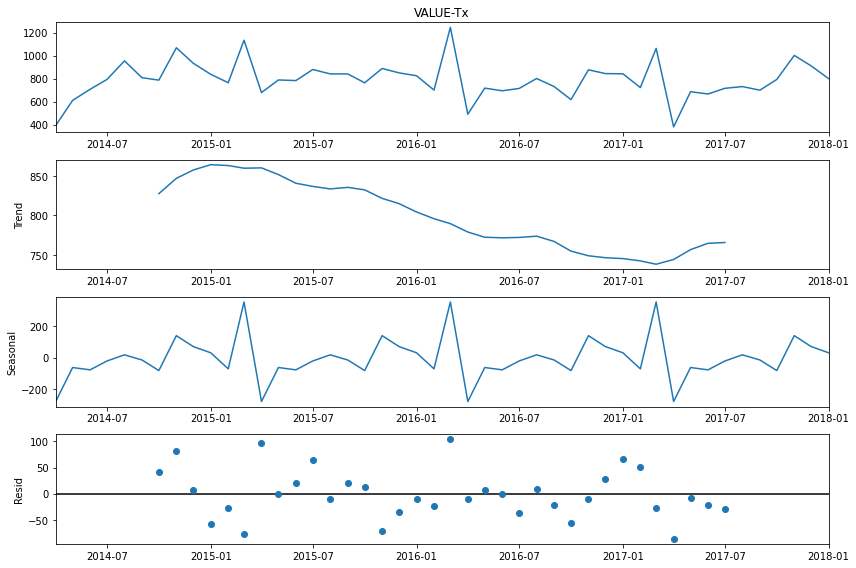

In [28]:
decompose(df_UP['VALUE-Tx'])

### Persistence Model - UP


RMSE: 498378.407
Residual Mean: -7759.440


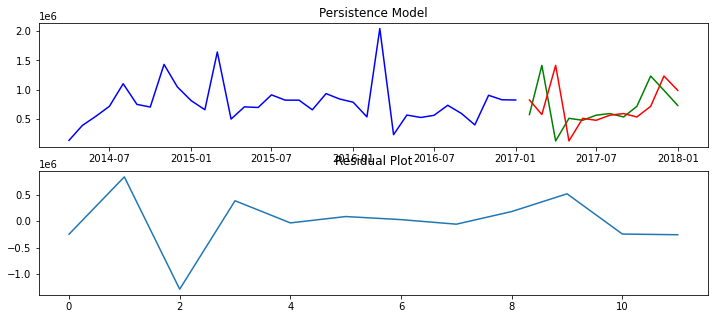

<Figure size 576x216 with 0 Axes>

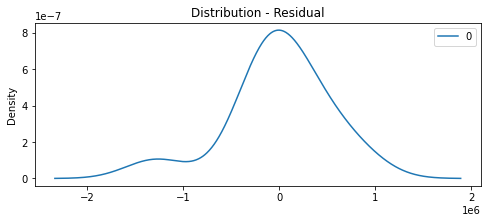

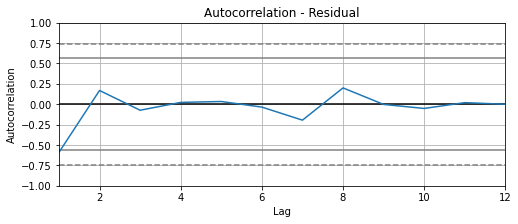

In [29]:
df_perf = pd.DataFrame(columns=['State','Method','RMSE','Residual-Mean'])
build_PersistenceModel(df_UP['VALUE'], df_perf, 'UP')


RMSE: 252.768
Residual Mean: -3.544


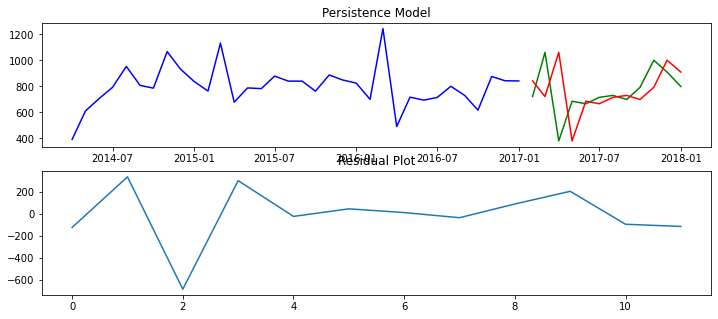

<Figure size 576x216 with 0 Axes>

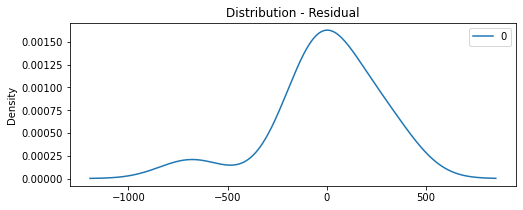

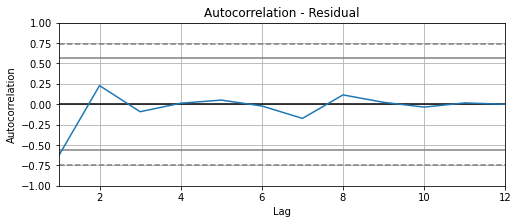

In [27]:
build_PersistenceModel(df_UP['VALUE-Tx'], df_perf, 'UP')

Take aways from the persistence model evaluation:

1. Persistence model RMSE = 498378.407 (for non-transformed 'VALUE')
2. Persistence model RMSE = 252.768 (for power transformed 'VALUE-Tx')
3. Residual mean = -3.544 for power transformed 'VALUE-Tx' (there is a negative forecast bias and the model is over forecasting)
4. Residual plot shows that residuals are not random (not Gaussian). There seems to be some pattern which the model has not captured.

### Simple Exponential Smoothing - UP

No handles with labels found to put in legend.


Test RMSE: 172.765
Residual Mean: 41.046


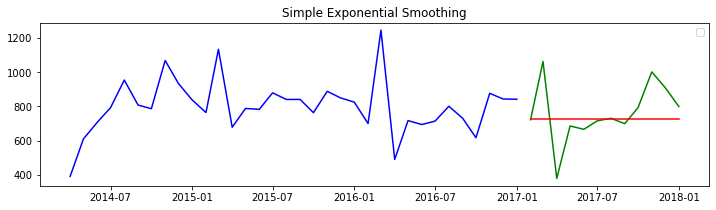

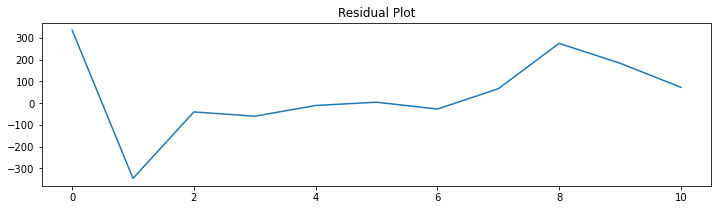

<Figure size 576x216 with 0 Axes>

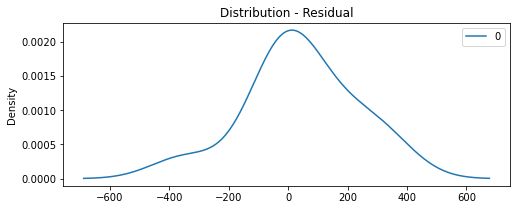

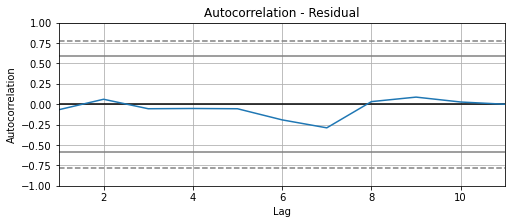

In [30]:
build_SES(df_UP['VALUE-Tx'], df_perf, 'UP', 0.05)

### Holt-Winters Method - UP

Test RMSE: 73.231
Residual Mean: 9.968


No handles with labels found to put in legend.


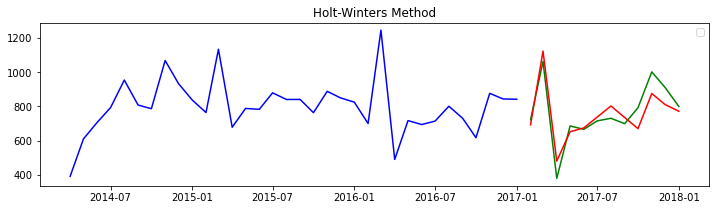

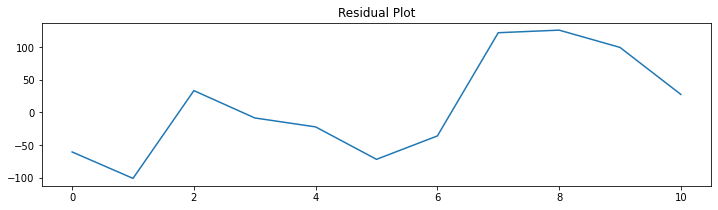

<Figure size 576x216 with 0 Axes>

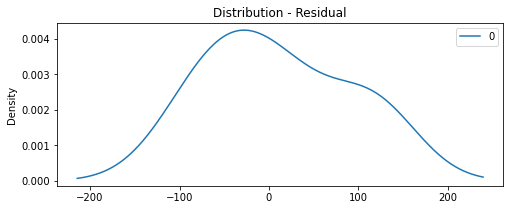

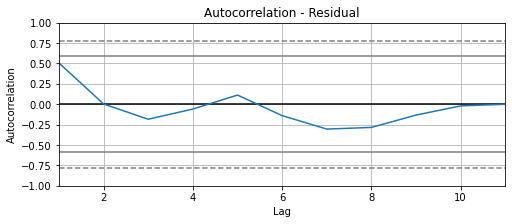

In [31]:
build_HoltWinters(df_UP['VALUE-Tx'], df_perf, 'UP','add','mul',12,0.009,0.00001)

#### Plot the ACF & PACF plots - UP

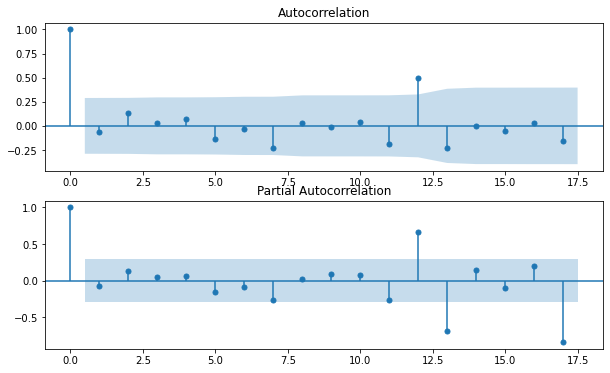

In [32]:
plot_ACF_PACF(df_UP['VALUE-Tx'])

### Build the ARIMA model - UP

In [33]:
def cross_val_ARIMA(data,p_values,d_values,q_values):
    split = len(data) - 12
    train, test = data[0:split], data[split:]
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order=(p,d,q)
                predictions = list()
                residuals = list()
                history = [x for x in train]
                
                for i in range(len(test)):
                    model = ARIMA(history, order=order)
                    model_fit = model.fit()

                    yhat = model_fit.forecast()[0]
                    predictions.append(yhat)

                    obs = test[i]
                    error = obs - yhat
                    history.append(obs)
                    residuals.append(error)

                residuals = pd.DataFrame(residuals)
                predictions = pd.DataFrame(predictions)
                predictions = predictions.set_index(test.index)

                rmse = np.sqrt(mean_squared_error(test, predictions))                
                print('RMSE is {} with order {}'.format(rmse,order))


In [34]:
cross_val_ARIMA(df_UP['VALUE-Tx'], [11,12], [0,2], [0,1,2,3])

KeyboardInterrupt: 

In [35]:
def build_ARIMA(data, df_perf, state, order):

    split = len(data) - 12
    train, test = data[0:split], data[split:]
    
    # Walk forward validation
    history = [x for x in train]
    predictions = list()
    residuals = list()

    for i in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()

        yhat = model_fit.forecast()[0]
        predictions.append(yhat)

        obs = test[i]
        error = obs - yhat
        history.append(obs)
        residuals.append(error)
#         print('Predicted=%.3f, Expected=%.3f, Error=%.3f' %(yhat,obs, error))

    residuals = pd.DataFrame(residuals)
    predictions = pd.DataFrame(predictions)
    predictions = predictions.set_index(test.index)

    rmse = np.sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: %.3f' %rmse)
    print('Residual Mean: %.3f' %residuals.mean())

    results = [state, 'ARIMA', '%.3f' %rmse, '%.3f' %residuals.mean()]
    df_perf.loc[len(df_perf)] = results
    
    plt.figure(figsize=(10,4))
    plt.figure(1)

    plt.subplot(211)
    plt.plot(train, color='blue')
    plt.plot(test, color = 'green')
    plt.plot(predictions, color='red')

    plt.subplot(212)
    plt.plot(residuals)

    # Analyze residuals
    plt.figure(figsize=(8,3))
    residuals.plot(kind='kde', figsize=(8,3))
    plt.title('Distribution - Residual')
    
    # Check the Autocorrelation for the residuals
    plt.figure(figsize=(8,3))
    autocorrelation_plot(residuals)
    plt.title('Autocorrelation - Residual')    


Test RMSE: 90.105
Residual Mean: -32.951


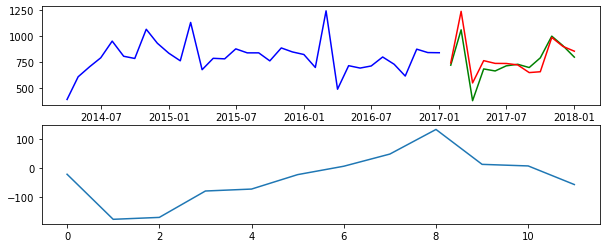

<Figure size 576x216 with 0 Axes>

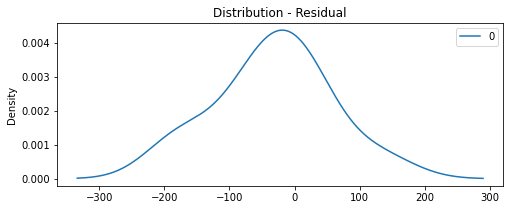

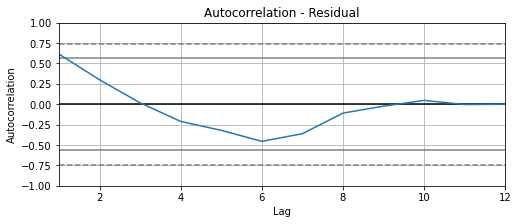

In [36]:
build_ARIMA(df_UP['VALUE-Tx'], df_perf, 'UP', (12,0,3))

Take aways from the ARIMA model evaluation:
1. ARIMA model RMSE = 90.105 (for power transformed 'VALUE-Tx')
2. Residual mean = -32.951 for power transformed 'VALUE-Tx' (there is a negative forecast bias and the model is over forecasting)
3. Residual plot shows that residuals are not entirely random (though very close to being a Gaussian distribution). There seems to be some pattern which the model has still not captured.

In [37]:
df_perf.head()

,State,Method,RMSE,Residual-Mean
0,UP,Persistence Model,498378.407,-7759.440
1,UP,SES,172.765,41.046
2,UP,Holt-Winters,73.231,9.968
3,UP,ARIMA,90.105,-32.951


Observations:
1. Based on the RMSE scores, Holt-Winters model seems to have the lowest RMSE value. Hence we will use this method to forecast the values for the next 3 months

#### Forecast for the next 3 months - UP

In [38]:
predictions_final = pd.DataFrame(columns=['Date','State','VALUE'])
predictions_final

,Date,State,VALUE


Residual Mean = 1.458


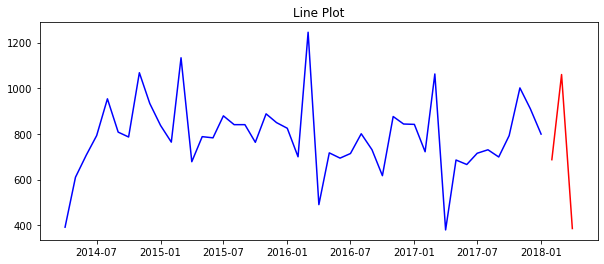

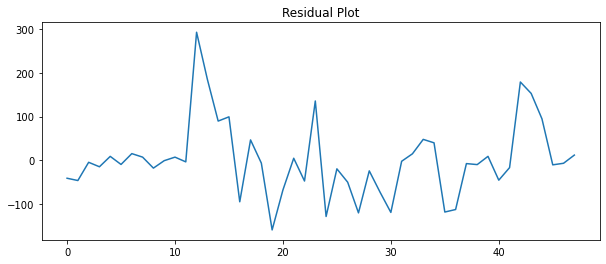

<Figure size 576x216 with 0 Axes>

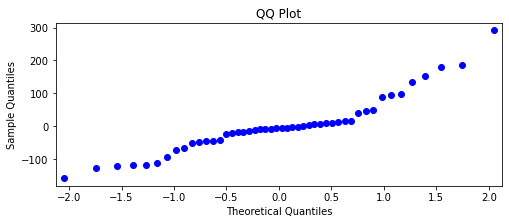

Text(0.5, 1.0, 'Autocorrelation - Residual')

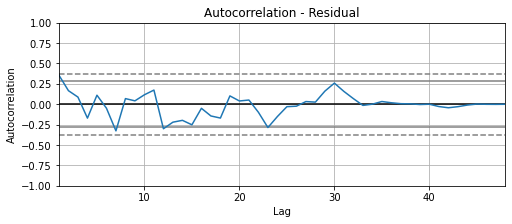

In [42]:
X = df_UP['VALUE-Tx']

# Walk forward validation
history = [x for x in X]
predictions_hw = list()
residuals_hw = list()

for i in range(0, 3):
    model = ExponentialSmoothing(history, trend='add', seasonal='mul', seasonal_periods=12)
    model = model.fit(smoothing_level=0.009, smoothing_slope=0.00001)
    yhat = model.forecast()
    
    predictions_hw.append(yhat)
    history.append(yhat)
#     print('Predicted=%.3f' %(yhat))

pred_temp = list(inv_boxcox(predictions_hw,lamda))

dates = pd.Series(['2018-02-01','2018-03-01', '2018-04-01'])
predictions_hw = pd.DataFrame({'Date':dates, 'VALUE':predictions_hw})
predictions_hw['Date'] = pd.to_datetime(predictions_hw['Date'])
predictions_hw = predictions_hw.set_index('Date')

predictions_UP = pd.DataFrame({'Date':dates, 'State':'Uttar Pradesh', 'VALUE':pred_temp})
predictions_UP.VALUE = predictions_UP.VALUE.apply(float)

predictions_final = predictions_final.append(predictions_UP)

residuals_hw = model.resid
print('Residual Mean = %.3f' %residuals_hw.mean())

plt.figure(figsize=(10,4))
plt.plot(X, color='blue')
plt.plot(predictions_hw, color='red')
plt.title('Line Plot')

plt.figure(figsize=(10,4))
plt.plot(residuals_hw)
plt.title('Residual Plot')

plt.figure(figsize=(8,3))
rcParams['figure.figsize']=8,3
fig = qqplot(residuals_hw)
plt.title('QQ Plot')
plt.show()

# Check the Autocorrelation for the residuals
plt.figure(figsize=(8,3))
autocorrelation_plot(residuals_hw)
plt.title('Autocorrelation - Residual')    


Text(0.5, 1.0, 'Autocorrelation - Residual')

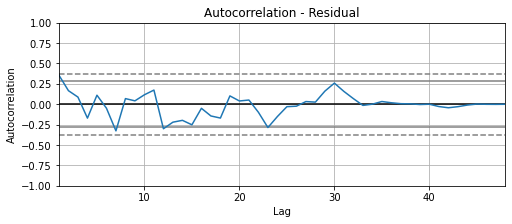

In [41]:
# Check the Autocorrelation for the residuals
plt.figure(figsize=(8,3))
autocorrelation_plot(residuals_hw)
plt.title('Autocorrelation - Residual')    


In [38]:
predictions_final.head()

,Date,State,VALUE
0,2018-02-01,Uttar Pradesh,5.190230e+05
1,2018-03-01,Uttar Pradesh,1.407193e+06
2,2018-04-01,Uttar Pradesh,1.378134e+05


### Data Analysis - Haryana

,VALUE,Year,Month
count,46.000000,46.000000,46.000000
mean,123200.639022,2015.652174,6.673913
std,54083.520877,1.139540,3.458030
min,11309.085000,2014.000000,1.000000
25%,94147.481250,2015.000000,4.000000
50%,127867.882500,2016.000000,7.000000
75%,151546.173750,2017.000000,9.750000
max,313321.500000,2018.000000,12.000000


Mean = 123200.639
Standard Deviation = 54083.521
Lambda: 0.775894


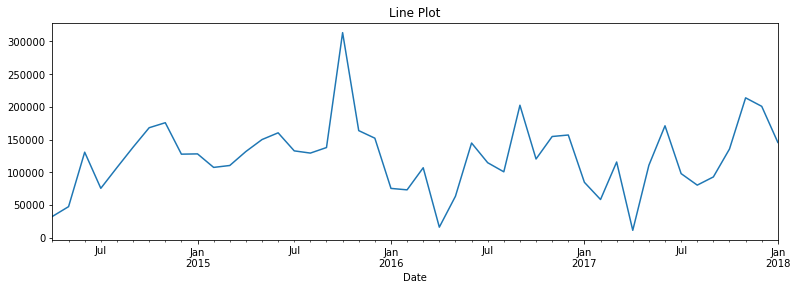

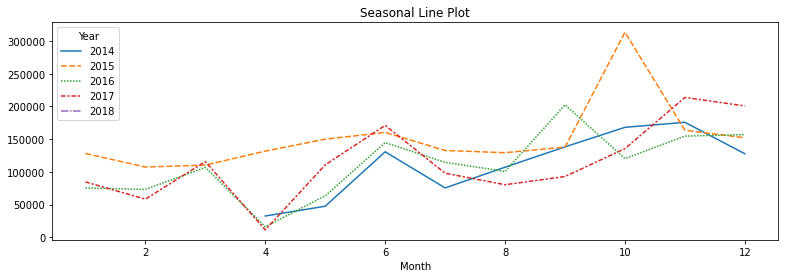

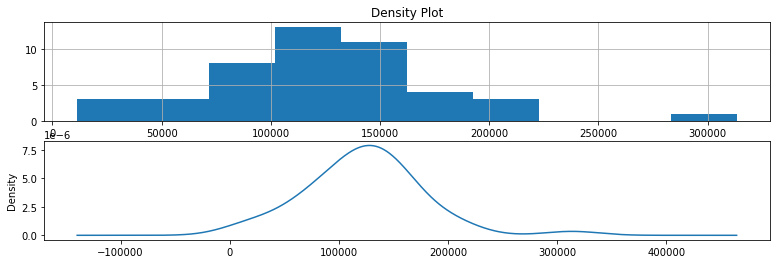

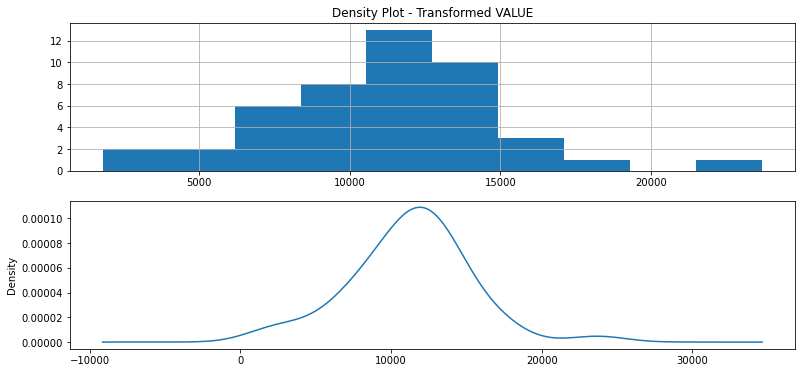

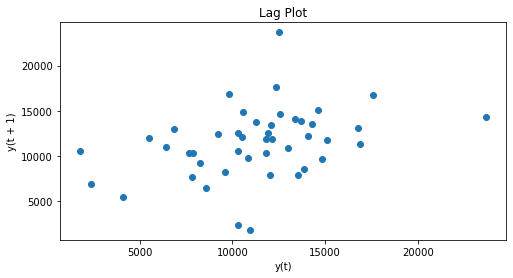

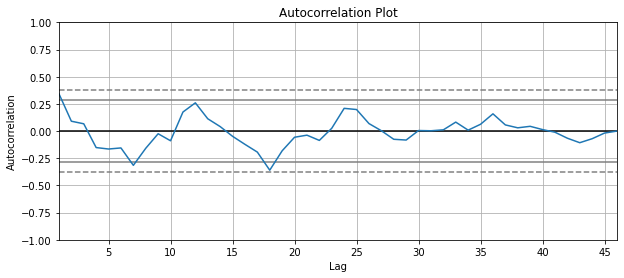

In [39]:
df_HR, lamda = data_analysis(df_HR)

Observations from the summary statistics:
1. The number is observations = 46 (as expected)
2. The mean is about 123200.639, which we will consider our level in this series
3. The standard deviation (avg spread from the mean) is relatively large at 54083.521
4. The percentiles along with the standard deviation suggest a large spread of the data

Observations from the Line Plot:
1. Sale is the higher in Oct, November followed by June
2. Sale is the lowest in April

Observations from the Density Plot:
1. Distribution is not Gaussian
2. Suggests the usage of data transformation to make it Gaussian. Let's try the boxcox transformation.

Observations from the Lag Plot:
1. The Lag plot shows a weak relationship of sale with its lag value. Let's try the autocorrelation plot to see if its correlated with any other day.

Observations from the Autocorrelation Plot:
1. Autocorrelation plot above shows that sale data is not correlated with any of its past data.

### Check for white noise - Haryana

In [40]:
check_whitenoise(df_HR['VALUE-Tx'])

Series Mean = 11271.555
2014 Mean = 10423.584
2015 Mean = 13361.676
2016 Mean = 10363.650
2017 Mean = 10575.687


Sales has non-zero mean & variance changes over time. Clearly the time series data is not white noise.

### Check for Random Walk - Haryana

In [41]:
check_stationarity(df_HR['VALUE-Tx'])

ADF Statistic -4.768
p-value 0.000063
Critical values:
	1%: -3.585
	5%: -2.928
	10%: -2.602


Test Statistic < critical value (1%) and hence we will reject the null hypothesis and say that the time series is stationary. This also proves that our time series is not a random walk.

### Decompose the time series data - Haryana

Seasonal Decompose


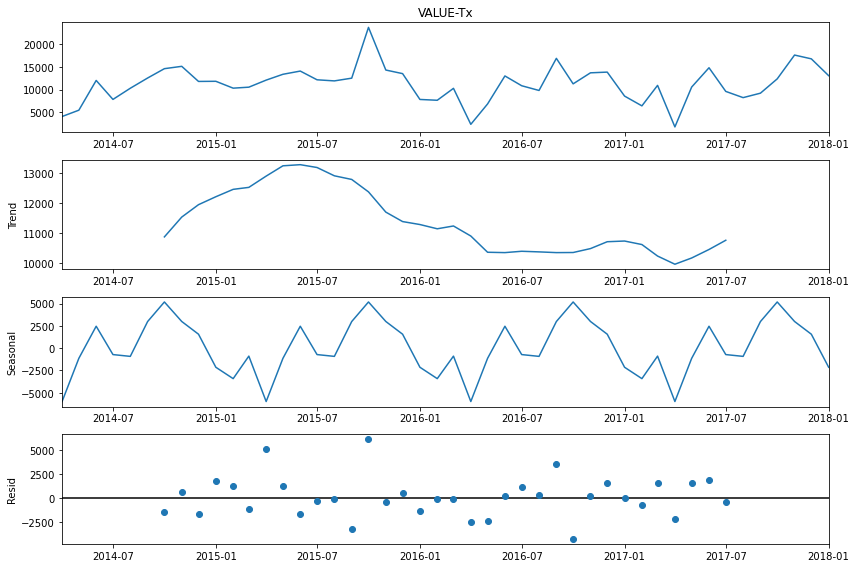

In [42]:
decompose(df_HR['VALUE-Tx'])

### Persistence Model - Haryana


RMSE: 4871.385
Residual Mean: 374.095


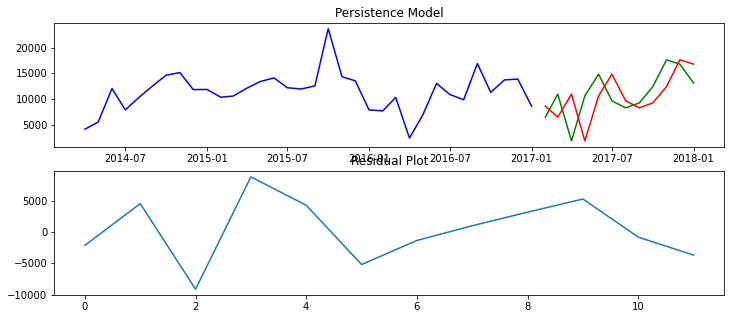

<Figure size 576x216 with 0 Axes>

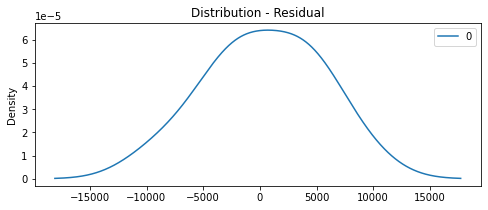

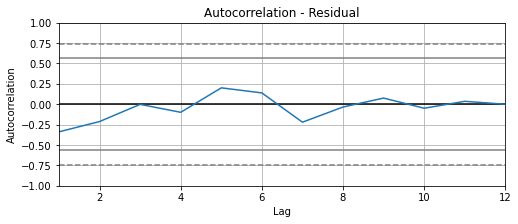

In [43]:
build_PersistenceModel(df_HR['VALUE-Tx'], df_perf, 'Haryana')

### Simple Exponential Smoothing - Haryana

No handles with labels found to put in legend.


Test RMSE: 4242.616
Residual Mean: 496.920


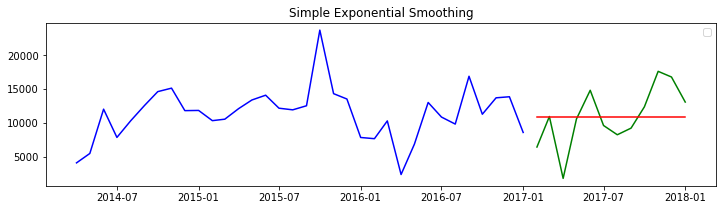

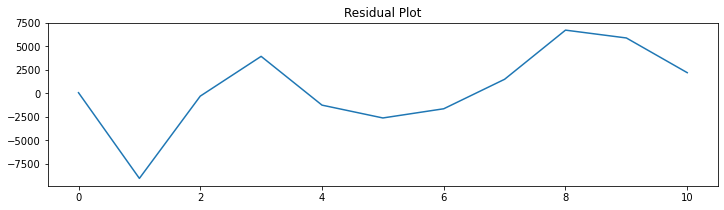

<Figure size 576x216 with 0 Axes>

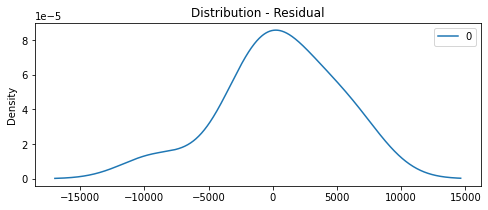

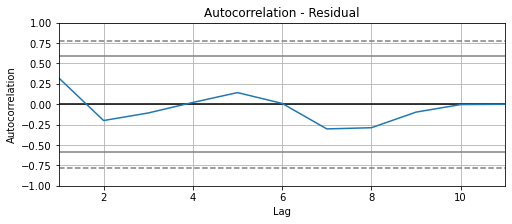

In [44]:
build_SES(df_HR['VALUE-Tx'], df_perf, 'Haryana', 0.07)

### Holt-Winters Method - Haryana

No handles with labels found to put in legend.


Test RMSE: 2412.547
Residual Mean: 472.221


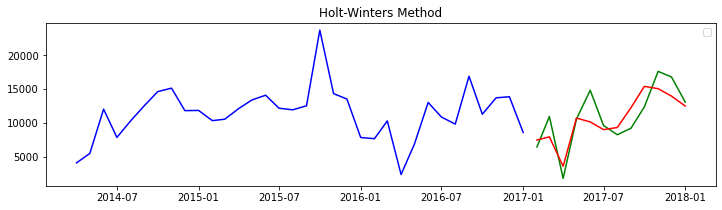

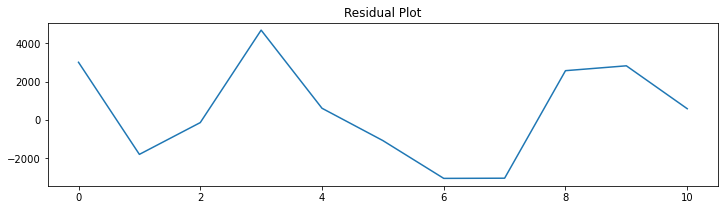

<Figure size 576x216 with 0 Axes>

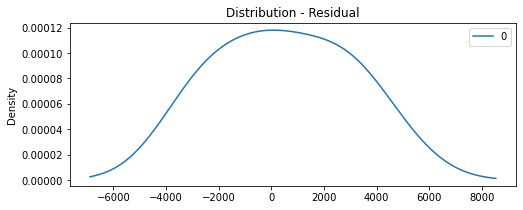

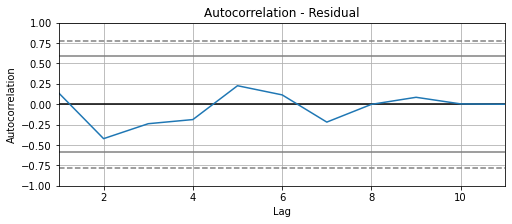

In [45]:
build_HoltWinters(df_HR['VALUE-Tx'], df_perf, 'Haryana','add','mul',12, 1.1, 0.00001)

#### Plot the ACF & PACF plots - Haryana

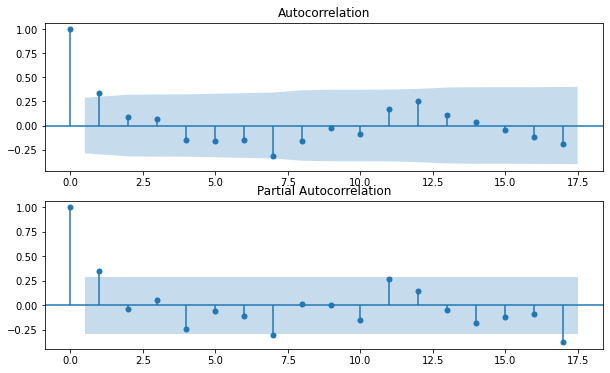

In [46]:
plot_ACF_PACF(df_HR['VALUE-Tx'])

### Build the ARIMA model - Haryana

In [47]:
cross_val_ARIMA(df_HR['VALUE-Tx'], [2,3,8], [0,1,2], [1])

RMSE is 4253.285024860057 with order (2, 0, 1)
RMSE is 4689.447180496206 with order (2, 1, 1)
RMSE is 4725.663790182254 with order (2, 2, 1)
RMSE is 4218.30075354568 with order (3, 0, 1)
RMSE is 4707.88974260098 with order (3, 1, 1)
RMSE is 4729.448469425973 with order (3, 2, 1)
RMSE is 4258.145256358107 with order (8, 0, 1)
RMSE is 4425.316336607279 with order (8, 1, 1)
RMSE is 4755.224618426239 with order (8, 2, 1)


Test RMSE: 4218.301
Residual Mean: 184.256


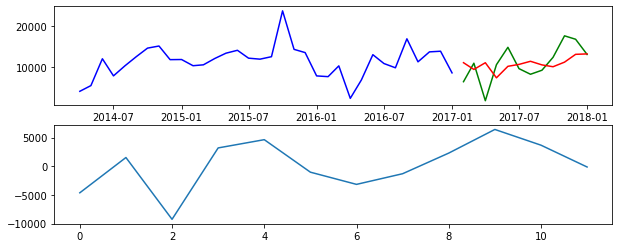

<Figure size 576x216 with 0 Axes>

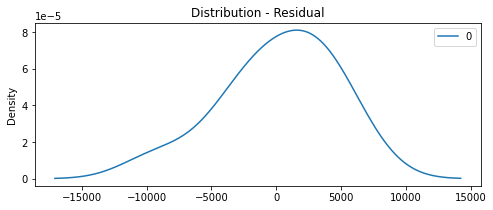

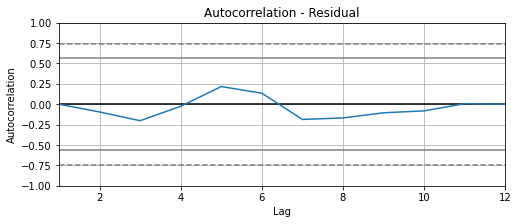

In [48]:
build_ARIMA(df_HR['VALUE-Tx'], df_perf, 'Haryana', (3,0,1))

In [49]:
df_perf[df_perf['State']=='Haryana']

,State,Method,RMSE,Residual-Mean
5,Haryana,Persistence Model,4871.385,374.095
6,Haryana,SES,4242.616,496.920
7,Haryana,Holt-Winters,2412.547,472.221
8,Haryana,ARIMA,4218.301,184.256


Observations:
1. Based on the RMSE scores, Holt-Winters model seems to have the lowest RMSE value. Hence we will use this method to forecast the values for the next 3 months

#### Forecast for the next 3 months - Haryana

Residual Mean = -737.975


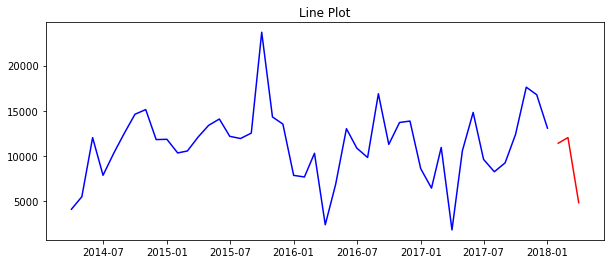

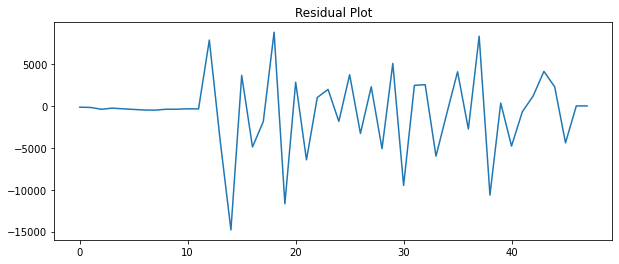

<Figure size 576x216 with 0 Axes>

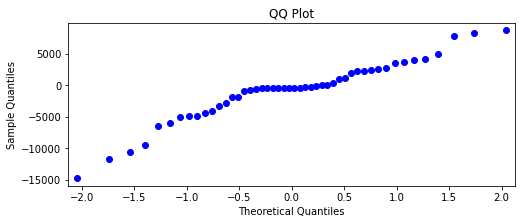

In [50]:
X = df_HR['VALUE-Tx']

# Walk forward validation
history = [x for x in X]
predictions_hw = list()
residuals_hw = list()

for i in range(0, 3):
    model = ExponentialSmoothing(history, trend='add', seasonal='mul', seasonal_periods=12)
    model = model.fit(smoothing_level=1.1, smoothing_slope=0.00001)
    yhat = model.forecast()
    
    predictions_hw.append(yhat)
    history.append(yhat)
#     print('Predicted=%.3f' %(yhat))

pred_temp = list(inv_boxcox(predictions_hw,lamda))

dates = pd.Series(['2018-02-01','2018-03-01', '2018-04-01'])
predictions_hw = pd.DataFrame({'Date':dates, 'VALUE':predictions_hw})
predictions_hw['Date'] = pd.to_datetime(predictions_hw['Date'])
predictions_hw = predictions_hw.set_index('Date')

predictions_HR = pd.DataFrame({'Date':dates, 'State':'Haryana', 'VALUE':pred_temp})
predictions_HR.VALUE = predictions_HR.VALUE.apply(float)

predictions_final = predictions_final.append(predictions_HR)

residuals_hw = model.resid
print('Residual Mean = %.3f' %residuals_hw.mean())

plt.figure(figsize=(10,4))
plt.plot(X, color='blue')
plt.plot(predictions_hw, color='red')
plt.title('Line Plot')

plt.figure(figsize=(10,4))
plt.plot(residuals_hw)
plt.title('Residual Plot')

plt.figure(figsize=(8,3))
rcParams['figure.figsize']=8,3
fig = qqplot(residuals_hw)
plt.title('QQ Plot')
plt.show()


In [51]:
predictions_final

,Date,State,VALUE
0,2018-02-01,Uttar Pradesh,5.190230e+05
1,2018-03-01,Uttar Pradesh,1.407193e+06
2,2018-04-01,Uttar Pradesh,1.378134e+05
0,2018-02-01,Haryana,1.220380e+05
1,2018-03-01,Haryana,1.307519e+05
2,2018-04-01,Haryana,4.021136e+04


### Data Analysis - HP

,VALUE,Year,Month
count,46.000000,46.000000,46.000000
mean,13384.789239,2015.652174,6.673913
std,6553.251609,1.139540,3.458030
min,165.375000,2014.000000,1.000000
25%,8002.395000,2015.000000,4.000000
50%,14349.217500,2016.000000,7.000000
75%,16765.110000,2017.000000,9.750000
max,26836.380000,2018.000000,12.000000


Mean = 13384.789
Standard Deviation = 6553.252
Lambda: 0.911237


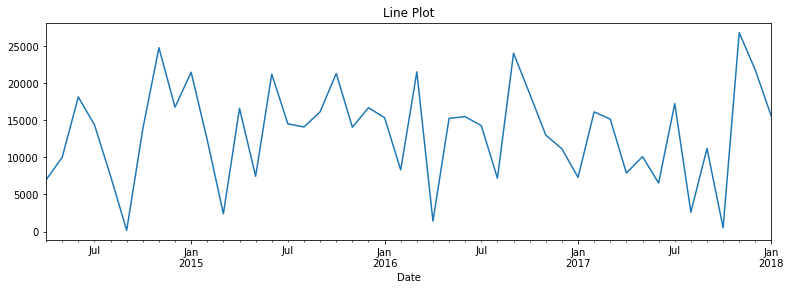

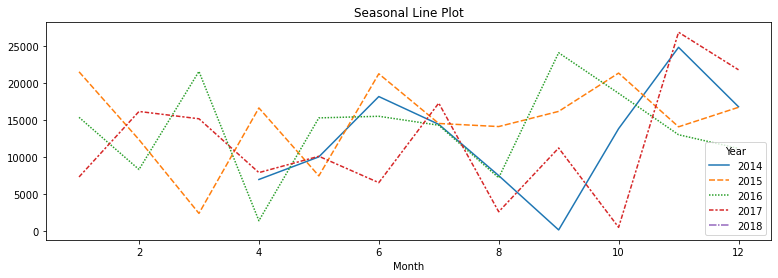

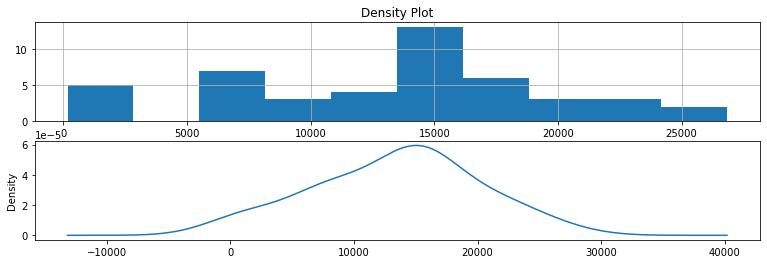

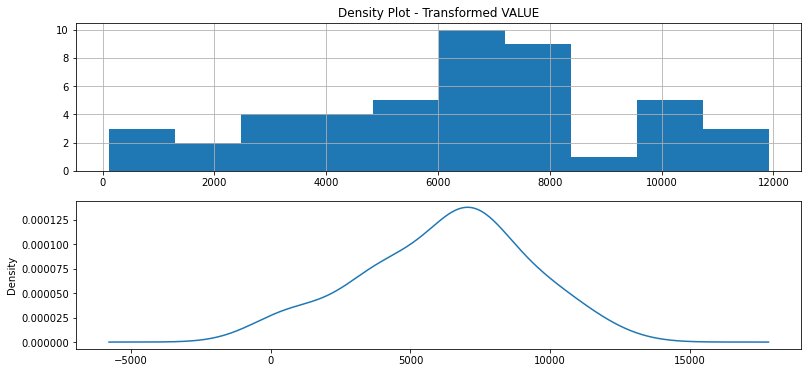

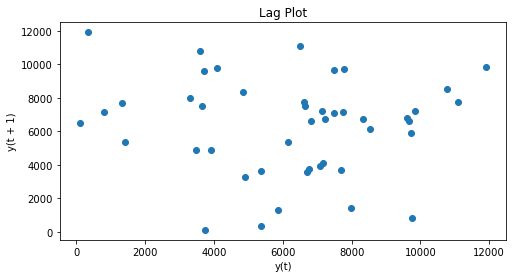

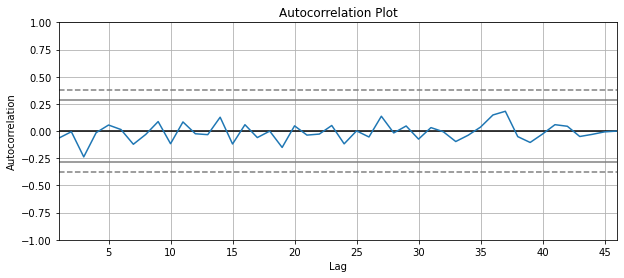

In [52]:
df_HP, lamda = data_analysis(df_HP)

### Check for white noise - HP

In [53]:
check_whitenoise(df_HP['VALUE-Tx'])

Series Mean = 6243.462
2014 Mean = 5848.990
2015 Mean = 6907.798
2016 Mean = 6440.832
2017 Mean = 5596.361


Sales has non-zero mean & variance changes over time. Clearly the time series data is not white noise.

### Check for Random Walk - HP

In [54]:
check_stationarity(df_HP['VALUE-Tx'])

ADF Statistic -7.057
p-value 0.000000
Critical values:
	1%: -3.585
	5%: -2.928
	10%: -2.602


Test Statistic < critical value (1%) and hence we will reject the null hypothesis and say that the time series is stationary. This also proves that our time series is not a random walk.

### Decompose the time series data - HP

Seasonal Decompose


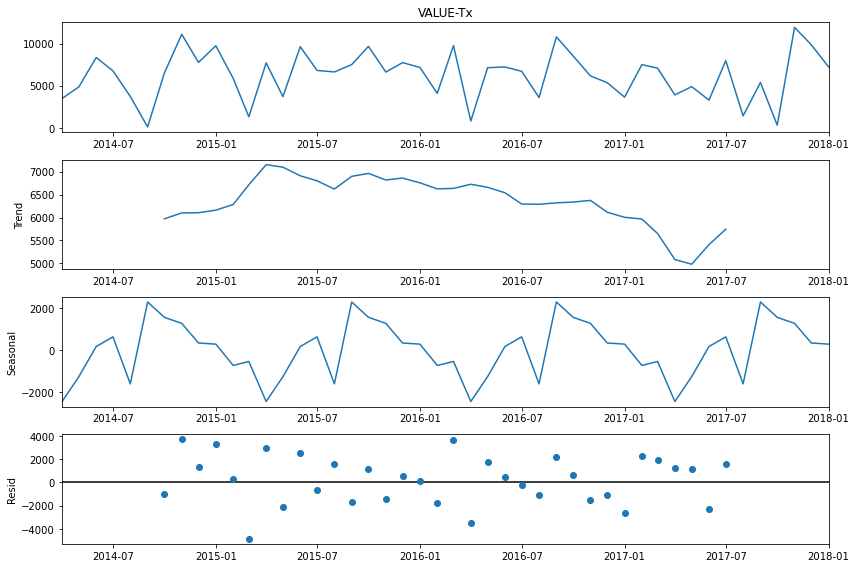

In [55]:
decompose(df_HP['VALUE-Tx'])

### Persistence Model - HP


RMSE: 4831.023
Residual Mean: 298.078


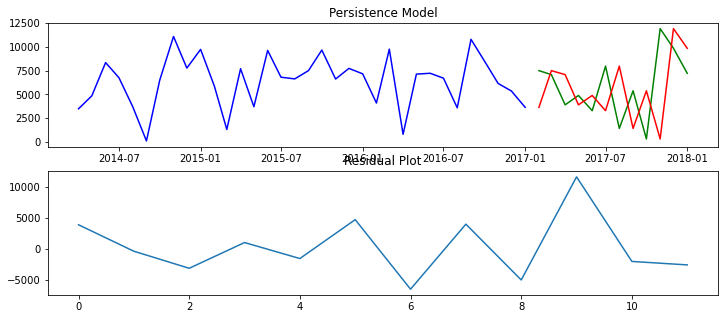

<Figure size 576x216 with 0 Axes>

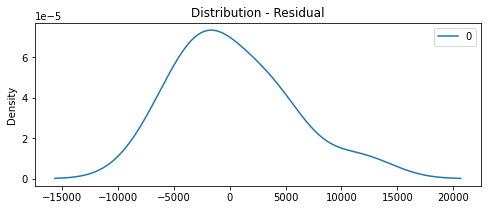

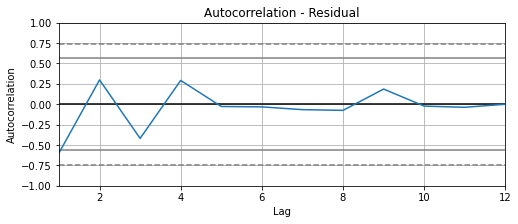

In [56]:
build_PersistenceModel(df_HP['VALUE-Tx'], df_perf, 'HP')

### Simple Exponential Smoothing - HP

No handles with labels found to put in legend.


Test RMSE: 3230.667
Residual Mean: 33.887


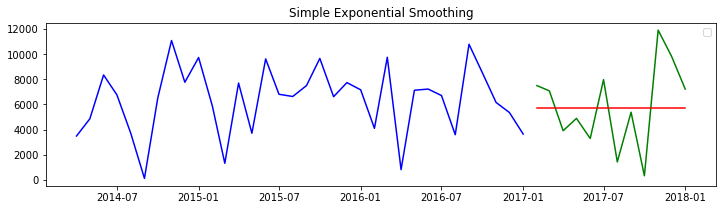

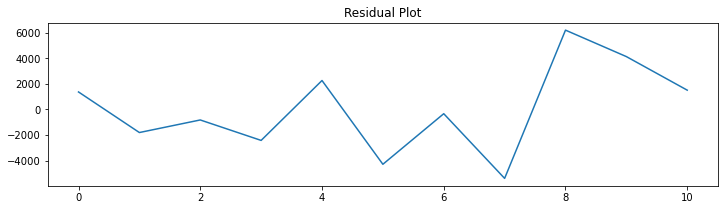

<Figure size 576x216 with 0 Axes>

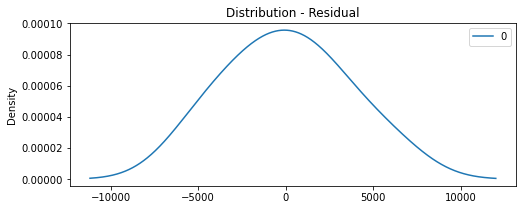

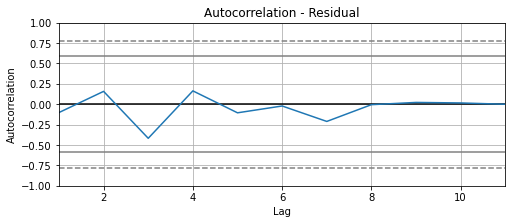

In [57]:
build_SES(df_HP['VALUE-Tx'], df_perf, 'HP', 0.3)

### Holt-Winters Method - HP

No handles with labels found to put in legend.


Test RMSE: 3648.815
Residual Mean: 1594.629


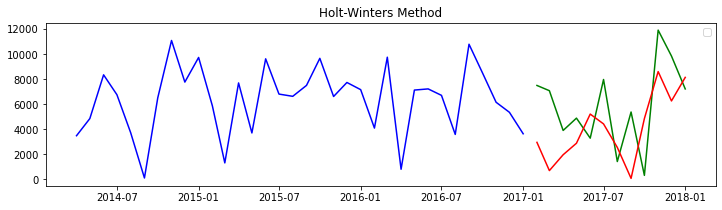

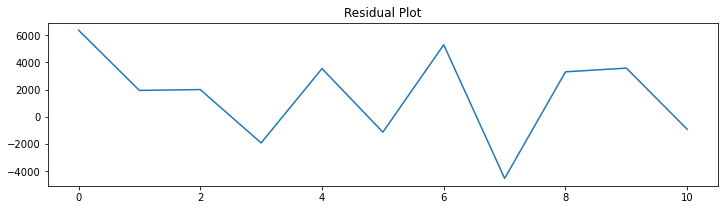

<Figure size 576x216 with 0 Axes>

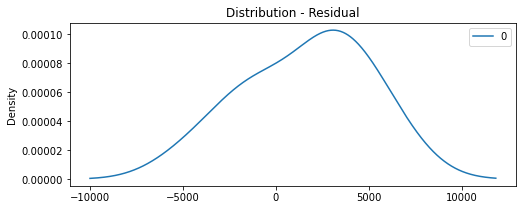

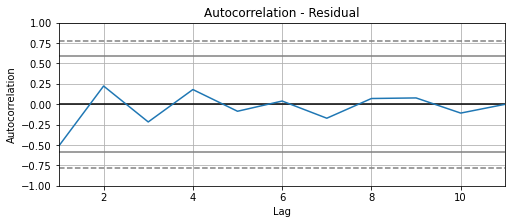

In [58]:
build_HoltWinters(df_HP['VALUE-Tx'], df_perf, 'HP', 'add','mul',12, 1.2, 0.00001)

#### Plot the ACF & PACF plots - HP

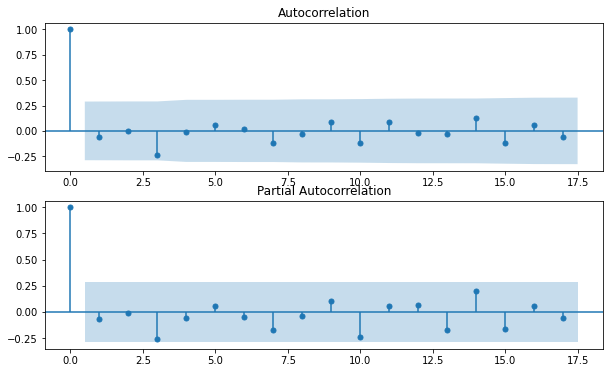

In [59]:
plot_ACF_PACF(df_HP['VALUE-Tx'])

### Build the ARIMA model - HP

In [60]:
cross_val_ARIMA(df_HP['VALUE-Tx'], [1,2], [0,1], [1,2,3])

RMSE is 3771.6895156027795 with order (1, 0, 1)
RMSE is 3791.9609458187238 with order (1, 0, 2)
RMSE is 3596.147786783567 with order (1, 0, 3)
RMSE is 3502.9362616706467 with order (1, 1, 1)
RMSE is 3579.5678036300596 with order (1, 1, 2)
RMSE is 3447.0428822397757 with order (1, 1, 3)
RMSE is 3801.233895450547 with order (2, 0, 1)
RMSE is 3686.9231139327176 with order (2, 0, 2)
RMSE is 3561.8590293892776 with order (2, 0, 3)
RMSE is 3553.6074085721707 with order (2, 1, 1)
RMSE is 3436.6143095322145 with order (2, 1, 2)
RMSE is 3646.4532055168925 with order (2, 1, 3)


Test RMSE: 3436.614
Residual Mean: -175.959


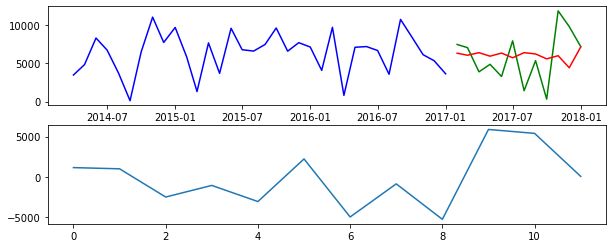

<Figure size 576x216 with 0 Axes>

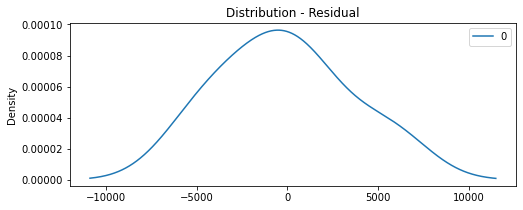

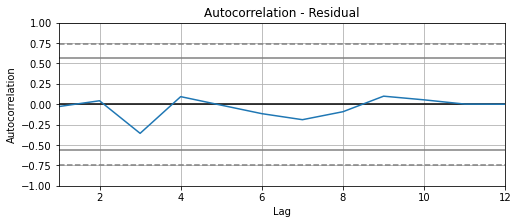

In [61]:
build_ARIMA(df_HP['VALUE-Tx'], df_perf, 'HP', (2,1,2)) # RMSE-3436.6, Mean: -175.959

In [62]:
df_perf[df_perf['State']=='HP']

,State,Method,RMSE,Residual-Mean
9,HP,Persistence Model,4831.023,298.078
10,HP,SES,3230.667,33.887
11,HP,Holt-Winters,3648.815,1594.629
12,HP,ARIMA,3436.614,-175.959


Observations:
1. Based on the RMSE scores, ARIMA model seems to have the lowest RMSE value. Hence we will use this method to forecast the values for the next 3 months

#### Forecast for the next 3 months - HP

Residual Mean = 667.435


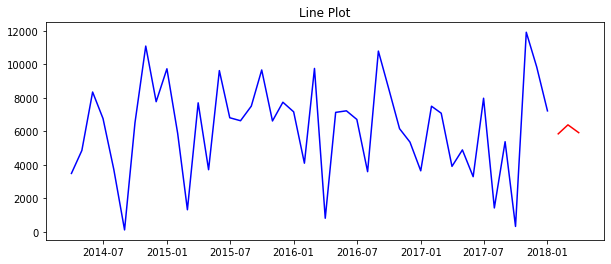

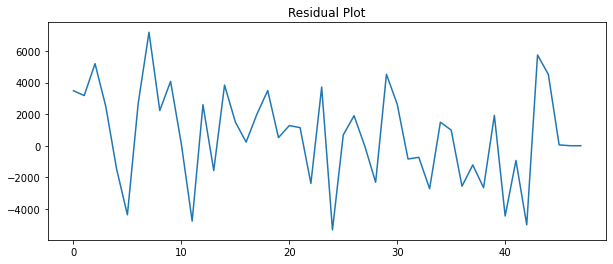

<Figure size 576x216 with 0 Axes>

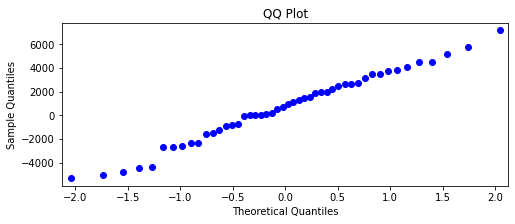

In [63]:
X = df_HP['VALUE-Tx']

# Walk forward validation
history = [x for x in X]
predictions = list()
residuals = list()

for i in range(0, 3):
    model = ARIMA(history, order=(2,1,2))
    model_final = model.fit()
    
    yhat = model_final.forecast()[0]

    predictions.append(yhat)
    history.append(yhat)
#     print('Predicted=%.3f' %(yhat))

pred_temp = list(inv_boxcox(predictions,lamda))

dates = pd.Series(['2018-02-01','2018-03-01', '2018-04-01'])
predictions = pd.DataFrame({'Date':dates, 'VALUE':predictions})
predictions['Date'] = pd.to_datetime(predictions['Date'])
predictions = predictions.set_index('Date')

predictions_HP = pd.DataFrame({'Date':dates, 'State':'Himachal Pradesh', 'VALUE':pred_temp})
predictions_HP.VALUE = predictions_HP.VALUE.apply(float)

predictions_final = predictions_final.append(predictions_HP)

residuals_hw = model_final.resid
print('Residual Mean = %.3f' %residuals_hw.mean())

plt.figure(figsize=(10,4))
plt.plot(X, color='blue')
plt.plot(predictions, color='red')
plt.title('Line Plot')

plt.figure(figsize=(10,4))
plt.plot(residuals_hw)
plt.title('Residual Plot')

plt.figure(figsize=(8,3))
rcParams['figure.figsize']=8,3
fig = qqplot(residuals_hw)
plt.title('QQ Plot')
plt.show()


### Data Analysis - UT

,VALUE,Year,Month
count,46.000000,46.000000,46.000000
mean,45611.537283,2015.652174,6.673913
std,13471.038307,1.139540,3.458030
min,20928.105000,2014.000000,1.000000
25%,34400.261250,2015.000000,4.000000
50%,42705.157500,2016.000000,7.000000
75%,55755.337500,2017.000000,9.750000
max,68877.270000,2018.000000,12.000000


Mean = 45611.537
Standard Deviation = 13471.038
Lambda: 0.559004


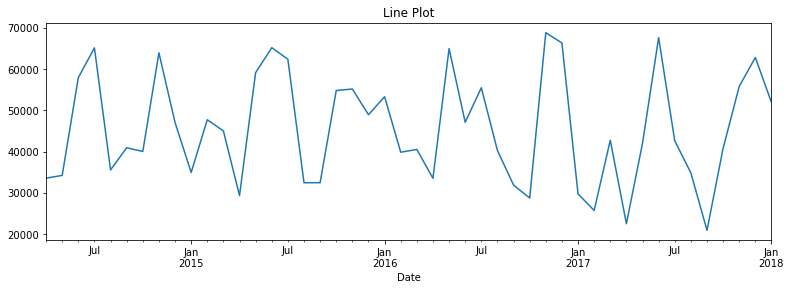

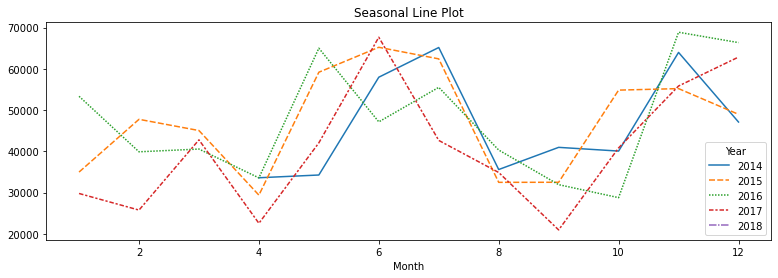

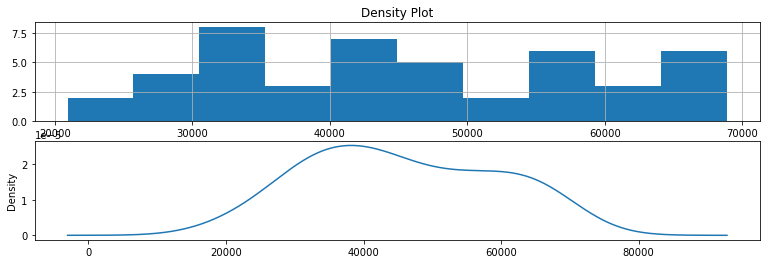

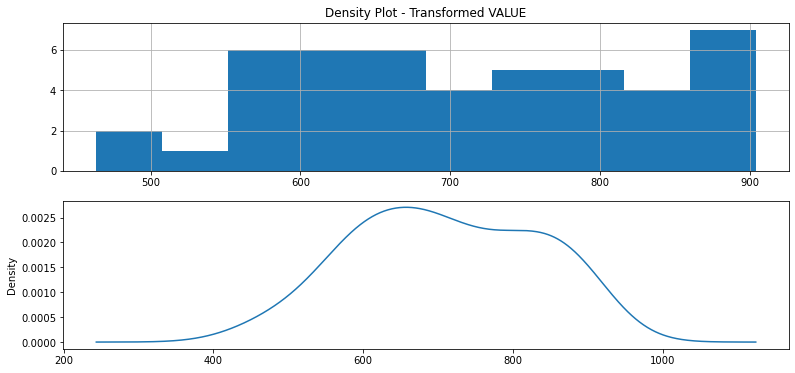

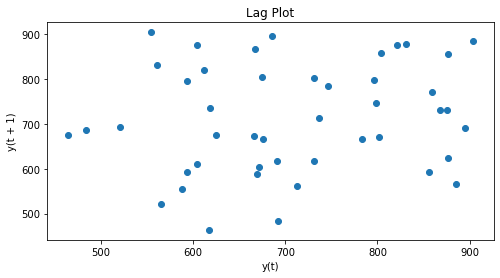

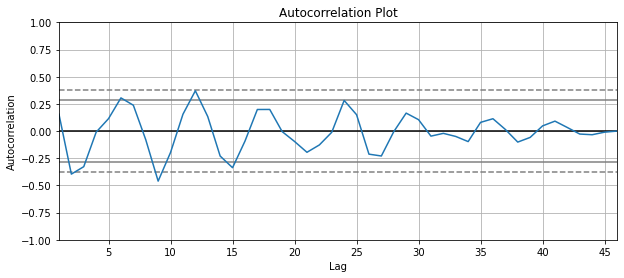

In [43]:
df_UT, lamda = data_analysis(df_UT)

### Check for white noise - UT

In [44]:
check_whitenoise(df_UT['VALUE-Tx'])

Series Mean = 709.890
2014 Mean = 719.869
2015 Mean = 726.584
2016 Mean = 727.810
2017 Mean = 662.637


Sales has non-zero mean & variance changes over time. Clearly the time series data is not white noise.

### Check for Random Walk - UT

In [45]:
check_stationarity(df_UT['VALUE-Tx'])

ADF Statistic -1.307
p-value 0.625966
Critical values:
	1%: -3.621
	5%: -2.944
	10%: -2.610


Test Statistic > critical values and hence we will accept the null hypothesis and say that the time series is not stationary.

In [46]:
df_UT['first_diff']=df_UT['VALUE-Tx']-df_UT['VALUE-Tx'].shift(1)
df_UT.head()

,VALUE,Year,Month,VALUE-Tx,first_diff
Date,,,,,
2014-04-01,33580.710,2014,4,604.509981,NaN
2014-05-01,34247.070,2014,5,611.206269,6.696288
2014-06-01,57970.215,2014,6,820.898750,209.692481
2014-07-01,65174.895,2014,7,876.575119,55.676369
2014-08-01,35574.525,2014,8,624.376960,-252.198159


In [47]:
check_stationarity(df_UT['first_diff'].dropna())

ADF Statistic -3.270
p-value 0.016284
Critical values:
	1%: -3.621
	5%: -2.944
	10%: -2.610


### Decompose the time series data - UT

Seasonal Decompose


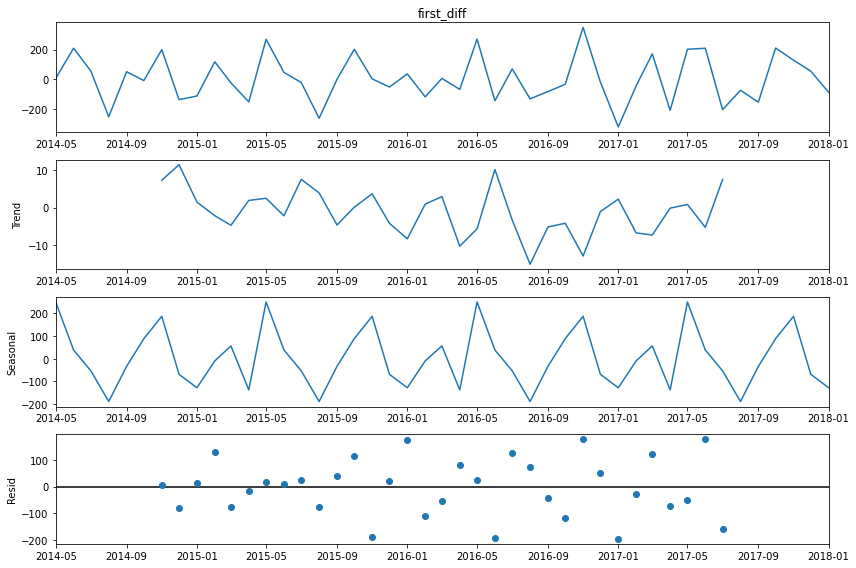

In [48]:
decompose(df_UT['first_diff'].dropna())

### Persistence Model - UT

In [49]:
df_UT.isnull().sum()

VALUE         0
Year          0
Month         0
VALUE-Tx      0
first_diff    1
dtype: int64

In [50]:
df_UT = df_UT.dropna()


RMSE: 257.663
Residual Mean: 19.444


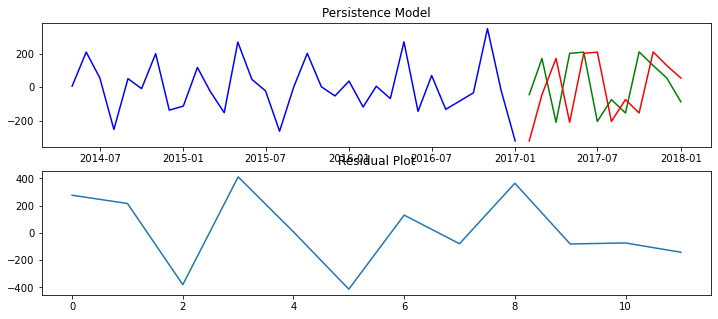

<Figure size 576x216 with 0 Axes>

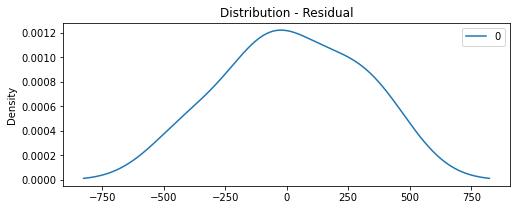

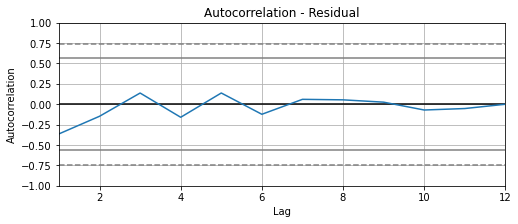

In [51]:
build_PersistenceModel(df_UT['first_diff'], df_perf, 'UT')

### Simple Exponential Smoothing - UT

No handles with labels found to put in legend.


Test RMSE: 158.184
Residual Mean: 16.331


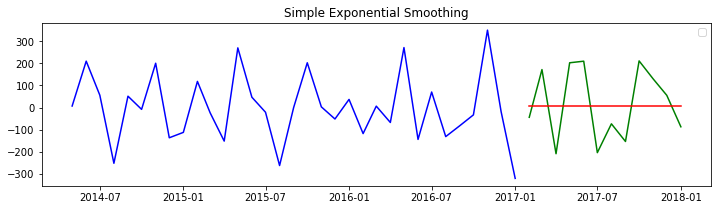

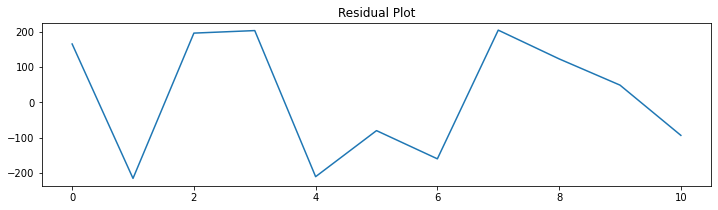

<Figure size 576x216 with 0 Axes>

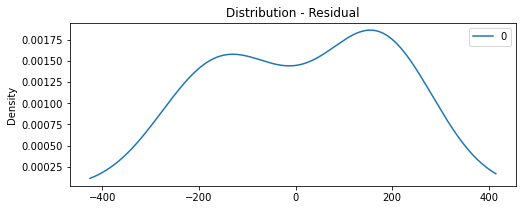

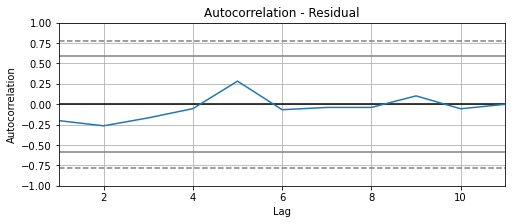

In [52]:
build_SES(df_UT['first_diff'], df_perf, 'UT', 0.0008)

### Holt-Winters Method - UT

In [53]:
df_UT['first_diff'].describe()

count     45.000000
mean       3.716610
std      156.811903
min     -320.510426
25%     -112.406211
50%       -8.365836
75%      118.094104
max      349.981267
Name: first_diff, dtype: float64

In [54]:
df_UT['first_diff'] = df_UT['first_diff'] + 330
df_UT['first_diff'].describe() 

count     45.000000
mean     333.716610
std      156.811903
min        9.489574
25%      217.593789
50%      321.634164
75%      448.094104
max      679.981267
Name: first_diff, dtype: float64

No handles with labels found to put in legend.


Test RMSE: 135.692
Residual Mean: 32.875


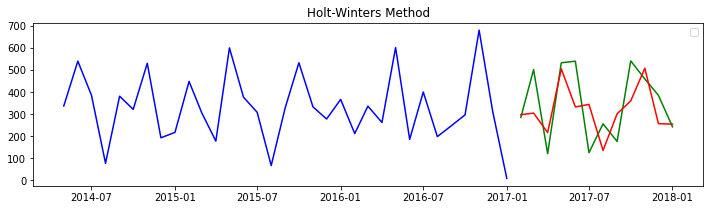

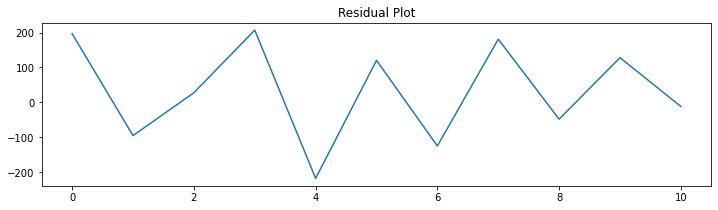

<Figure size 576x216 with 0 Axes>

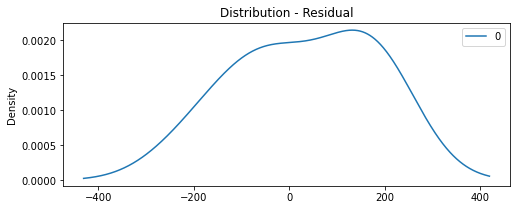

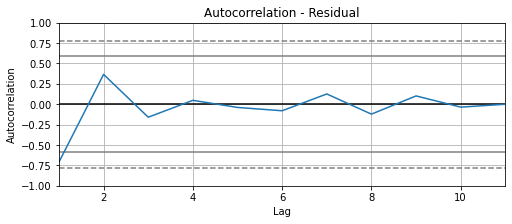

In [55]:
build_HoltWinters(df_UT['first_diff'], df_perf, 'UT','add', 'mul',12, 0.08, 0.00001)

#### Plot the ACF & PACF plots - UT

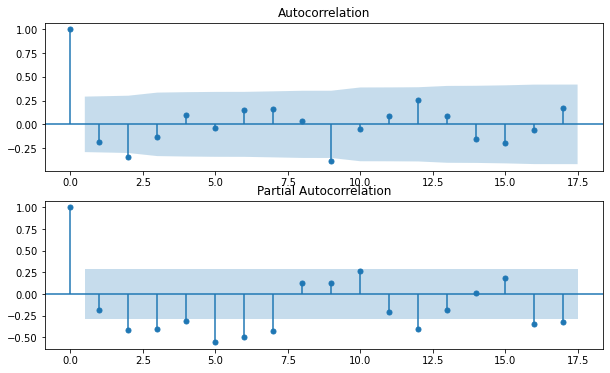

In [56]:
plot_ACF_PACF(df_UT['first_diff'])

### Build the ARIMA model - UT

In [57]:
df_UT['first_diff'] = df_UT['first_diff'] - 330

In [79]:
cross_val_ARIMA(df_UT['first_diff'], [2,8,14], [0,1], [2,5])

RMSE is 151.1450789117395 with order (2, 0, 2)
RMSE is 145.19509173334322 with order (2, 0, 5)
RMSE is 138.5699230180096 with order (2, 1, 2)
RMSE is 139.59621848319813 with order (2, 1, 5)
RMSE is 135.89168286095025 with order (8, 0, 2)
RMSE is 117.73585447713474 with order (8, 0, 5)
RMSE is 129.52093629991023 with order (8, 1, 2)
RMSE is 140.49788647008222 with order (8, 1, 5)
RMSE is 140.68291475662352 with order (14, 0, 2)
RMSE is 115.13360705852632 with order (14, 0, 5)
RMSE is 141.67561714856228 with order (14, 1, 2)
RMSE is 146.5181505183841 with order (14, 1, 5)


Test RMSE: 115.134
Residual Mean: 30.721


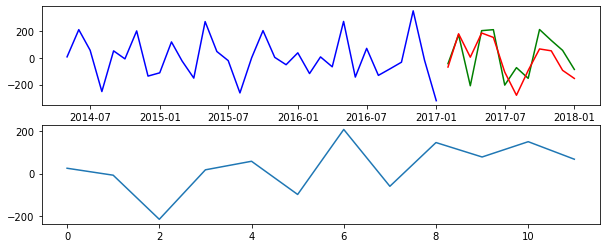

<Figure size 576x216 with 0 Axes>

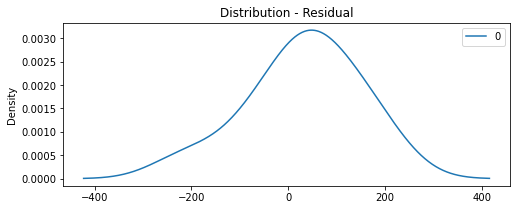

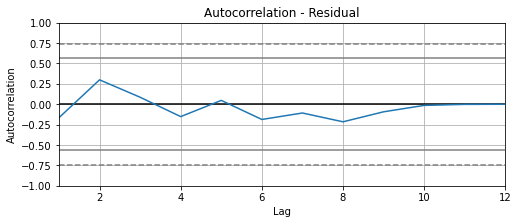

In [58]:
build_ARIMA(df_UT['first_diff'], df_perf, 'UT', (14,0,5)) # RMSE: 115.134, Mean: 30.72
# build_ARIMA(df_UT['first_diff'], df_perf, 'UT', (8,0,5)) # RMSE: 117.736, Mean: -5.075

In [59]:
df_perf[df_perf['State']=='UT'].sort_values(by=['RMSE'], ascending=True)

,State,Method,RMSE,Residual-Mean
7,UT,ARIMA,115.134,30.721
6,UT,Holt-Winters,135.692,32.875
5,UT,SES,158.184,16.331
4,UT,Persistence Model,257.663,19.444


Observations:
1. Based on the RMSE scores, ARIMA model seems to have the lowest RMSE value. Hence we will use this method to forecast the values for the next 3 months

#### Forecast for the next 3 months - UT

Residual Mean = 10.966


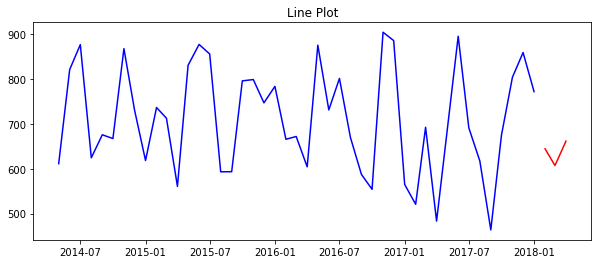

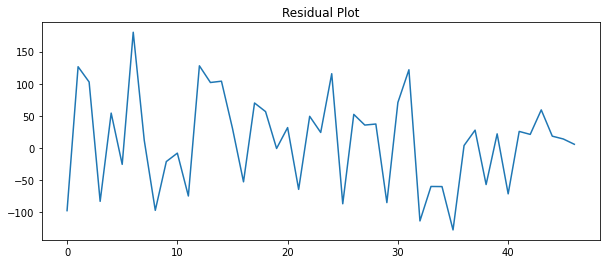

<Figure size 576x216 with 0 Axes>

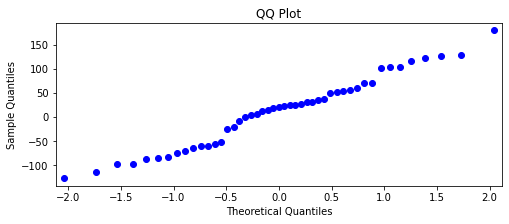

In [82]:
X = df_UT['VALUE-Tx']

# Walk forward validation
history = [x for x in X]
predictions = list()
residuals = list()

for i in range(0, 3):
    model = ARIMA(history, order=(14,0,5))
    model_final = model.fit()
    
    yhat = model_final.forecast()[0]

    predictions.append(yhat)
    history.append(yhat)
#     print('Predicted=%.3f' %(yhat))

pred_temp = list(inv_boxcox(predictions,lamda))

dates = pd.Series(['2018-02-01','2018-03-01', '2018-04-01'])
predictions = pd.DataFrame({'Date':dates, 'VALUE':predictions})
predictions['Date'] = pd.to_datetime(predictions['Date'])
predictions = predictions.set_index('Date')
# print(predictions)

predictions_UT = pd.DataFrame({'Date':dates, 'State':'Uttarakhand', 'VALUE':pred_temp})
predictions_UT.VALUE = predictions_UT.VALUE.apply(float)

predictions_final = predictions_final.append(predictions_UT)

residuals_hw = model_final.resid
print('Residual Mean = %.3f' %residuals_hw.mean())

plt.figure(figsize=(10,4))
plt.plot(X, color='blue')
plt.plot(predictions, color='red')
plt.title('Line Plot')

plt.figure(figsize=(10,4))
plt.plot(residuals_hw)
plt.title('Residual Plot')

plt.figure(figsize=(8,3))
rcParams['figure.figsize']=8,3
fig = qqplot(residuals_hw)
plt.title('QQ Plot')
plt.show()

In [83]:
predictions_final.tail(15)

,Date,State,VALUE
0,2018-02-01,Uttar Pradesh,5.190230e+05
1,2018-03-01,Uttar Pradesh,1.407193e+06
2,2018-04-01,Uttar Pradesh,1.378134e+05
0,2018-02-01,Haryana,1.220380e+05
1,2018-03-01,Haryana,1.307519e+05
2,2018-04-01,Haryana,4.021136e+04
0,2018-02-01,Himachal Pradesh,1.229372e+04
1,2018-03-01,Himachal Pradesh,1.353829e+04
2,2018-04-01,Himachal Pradesh,1.245728e+04
0,2018-02-01,Uttarakhand,3.764495e+04


### Data Analysis - Punjab

,VALUE,Year,Month
count,46.000000,46.000000,46.000000
mean,175568.345217,2015.652174,6.673913
std,79755.238552,1.139540,3.458030
min,44783.685000,2014.000000,1.000000
25%,120496.038750,2015.000000,4.000000
50%,164284.537500,2016.000000,7.000000
75%,206760.060000,2017.000000,9.750000
max,426452.310000,2018.000000,12.000000


Mean = 175568.345
Standard Deviation = 79755.239
Lambda: 0.420989


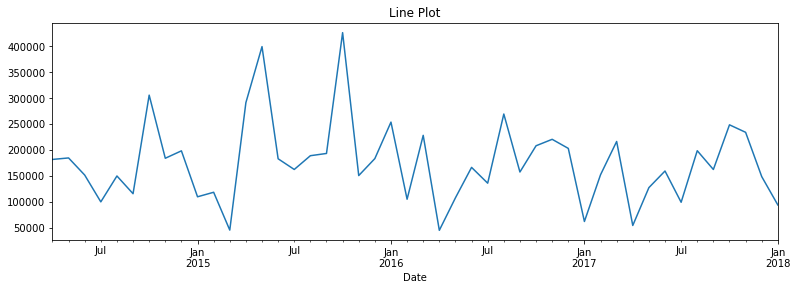

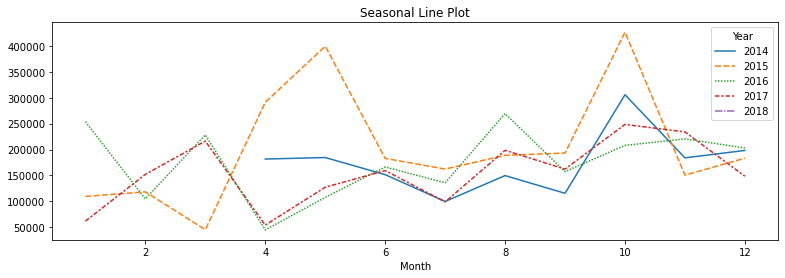

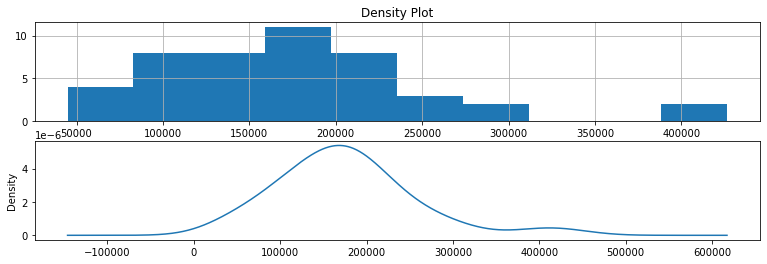

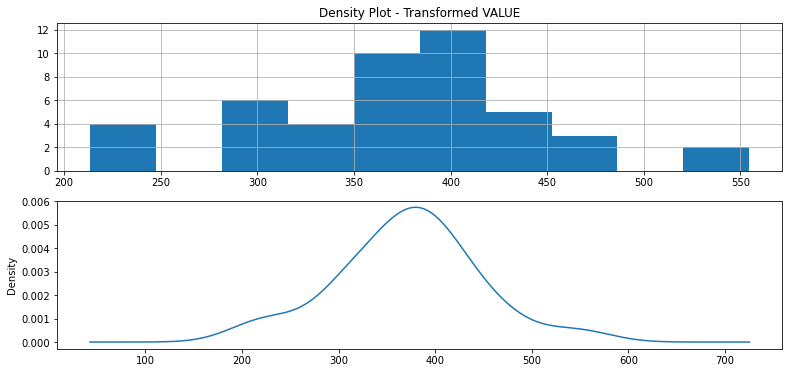

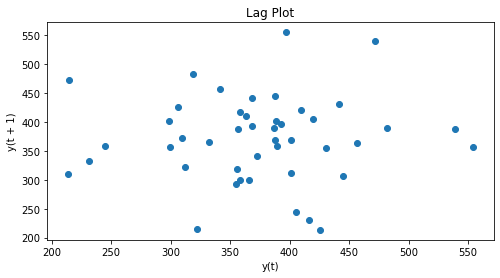

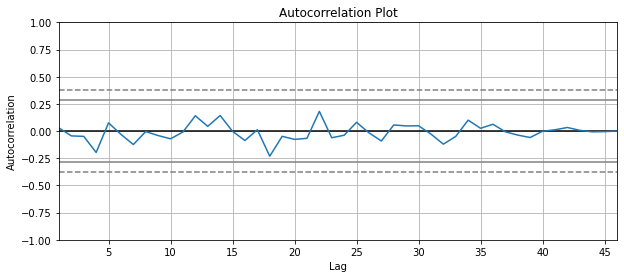

In [84]:
df_PN, lamda = data_analysis(df_PN)

### Check for white noise - Punjab

In [85]:
check_whitenoise(df_PN['VALUE-Tx'])

Series Mean = 371.479
2014 Mean = 375.520
2015 Mean = 392.085
2016 Mean = 372.343
2017 Mean = 353.603


### Check for Random Walk - Punjab

In [86]:
check_stationarity(df_PN['VALUE-Tx'])

ADF Statistic -6.283
p-value 0.000000
Critical values:
	1%: -3.585
	5%: -2.928
	10%: -2.602


Test Statistic < critical value (1%) and hence we will reject the null hypothesis and say that the time series is stationary. This also proves that our time series is not a random walk.

### Decompose the time series data - Punjab

Seasonal Decompose


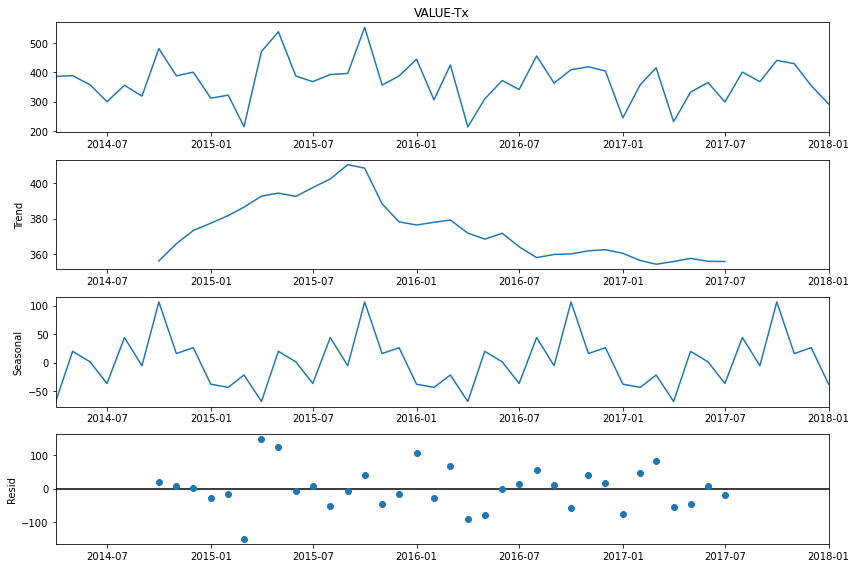

In [87]:
decompose(df_PN['VALUE-Tx'])

### Persistence Model - Punjab


RMSE: 88.011
Residual Mean: 3.944


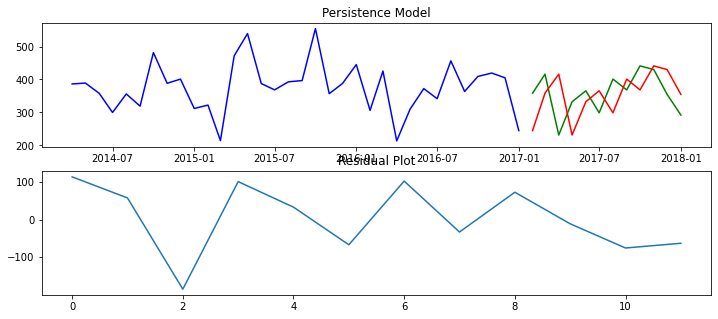

<Figure size 576x216 with 0 Axes>

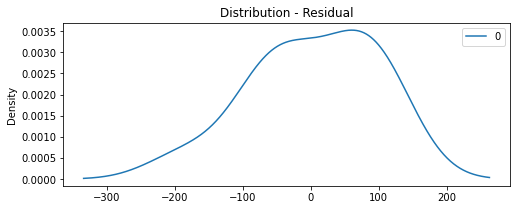

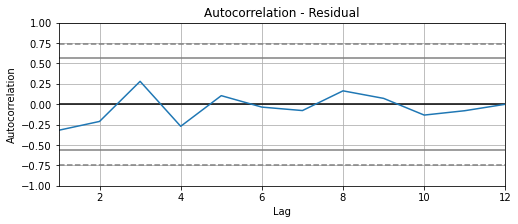

In [88]:
build_PersistenceModel(df_PN['VALUE-Tx'], df_perf, 'PN')

### Simple Exponential Smoothing - Punjab

No handles with labels found to put in legend.


Test RMSE: 59.432
Residual Mean: -4.093


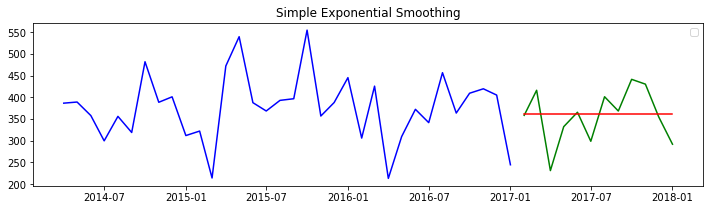

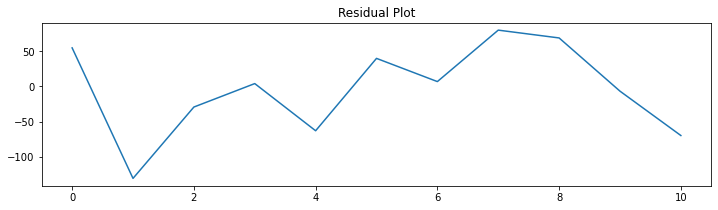

<Figure size 576x216 with 0 Axes>

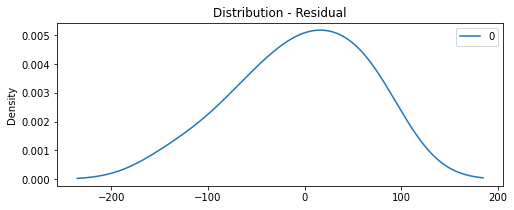

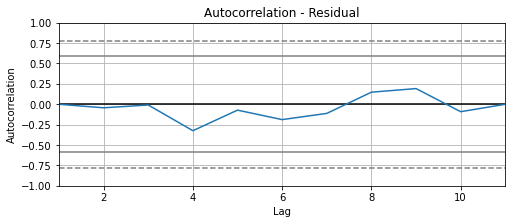

In [89]:
build_SES(df_PN['VALUE-Tx'], df_perf, 'PN',0.2)

### Holt-Winters Method - Punjab

No handles with labels found to put in legend.


Test RMSE: 47.193
Residual Mean: -6.186


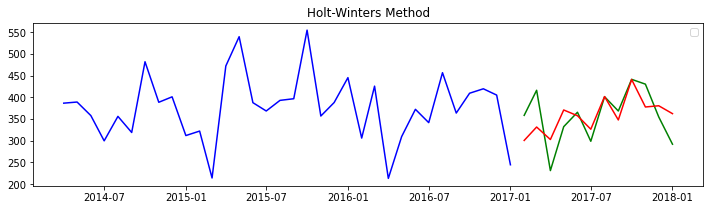

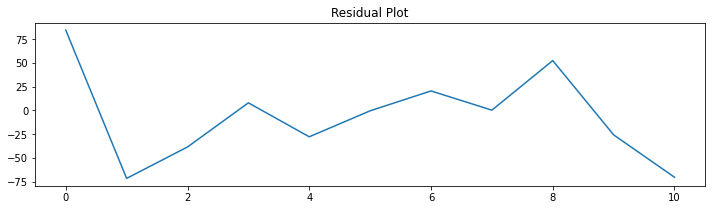

<Figure size 576x216 with 0 Axes>

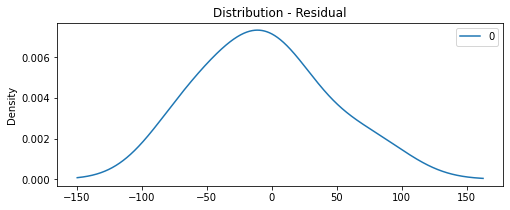

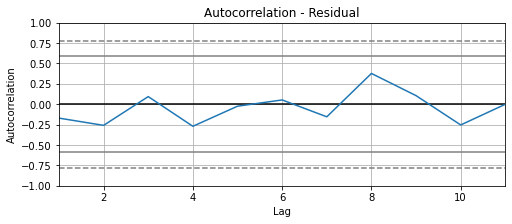

In [90]:
build_HoltWinters(df_PN['VALUE-Tx'], df_perf, 'PN','add','mul',12,0.01,0.00002)

#### Plot the ACF & PACF plots - Punjab

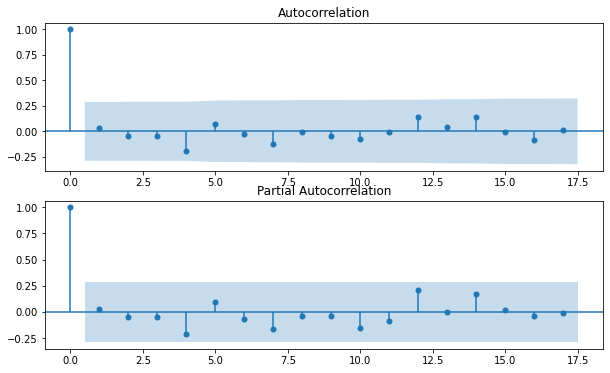

In [91]:
plot_ACF_PACF(df_PN['VALUE-Tx'])

### Build the ARIMA model - Punjab

In [92]:
cross_val_ARIMA(df_PN['VALUE-Tx'], [1,2,4], [0,1], [1,2,4])

RMSE is 66.48699917653974 with order (1, 0, 1)
RMSE is 65.55927251533701 with order (1, 0, 2)
RMSE is 78.58245307682571 with order (1, 0, 4)
RMSE is 62.33895558959922 with order (1, 1, 1)
RMSE is 61.78901654936945 with order (1, 1, 2)
RMSE is 64.25016319581651 with order (1, 1, 4)
RMSE is 69.90460643962295 with order (2, 0, 1)
RMSE is 73.37424184889876 with order (2, 0, 2)
RMSE is 78.1126554823952 with order (2, 0, 4)
RMSE is 62.47834744768261 with order (2, 1, 1)
RMSE is 63.81964255788638 with order (2, 1, 2)
RMSE is 63.58206788213378 with order (2, 1, 4)
RMSE is 67.49360527518462 with order (4, 0, 1)
RMSE is 77.26505420394231 with order (4, 0, 2)
RMSE is 79.46619069671901 with order (4, 0, 4)
RMSE is 66.22905007983178 with order (4, 1, 1)
RMSE is 66.60189471140194 with order (4, 1, 2)
RMSE is 73.74255750512194 with order (4, 1, 4)


Test RMSE: 61.789
Residual Mean: -15.320


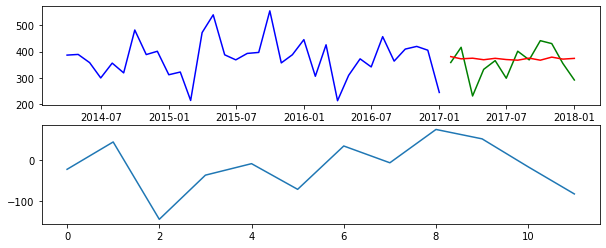

<Figure size 576x216 with 0 Axes>

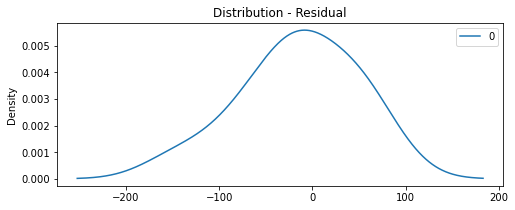

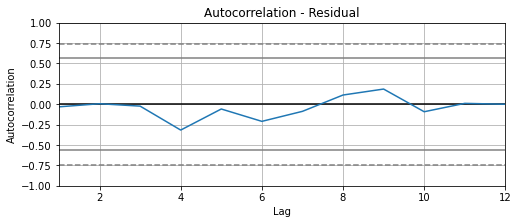

In [93]:
build_ARIMA(df_PN['VALUE-Tx'], df_perf, 'PN', (1,1,2))

In [94]:
df_perf[df_perf['State']=='PN'].sort_values(by=['RMSE'], ascending=False)#[0:1]

,State,Method,RMSE,Residual-Mean
17,PN,Persistence Model,88.011,3.944
20,PN,ARIMA,61.789,-15.320
18,PN,SES,59.432,-4.093
19,PN,Holt-Winters,47.193,-6.186


Observations:
1. Based on the RMSE scores, Holt-Winters model seems to have the lowest RMSE value. Hence we will use this method to forecast the values for the next 3 months

#### Forecast for the next 3 months - Punjab

Residual Mean = 4.948


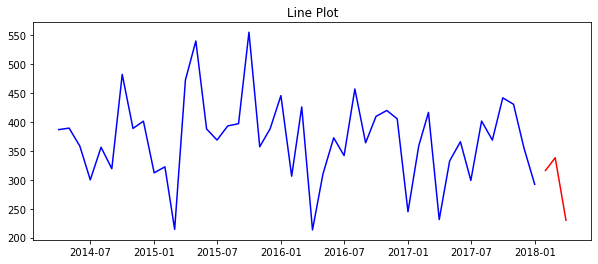

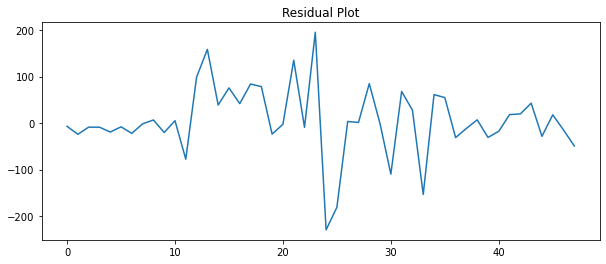

<Figure size 576x216 with 0 Axes>

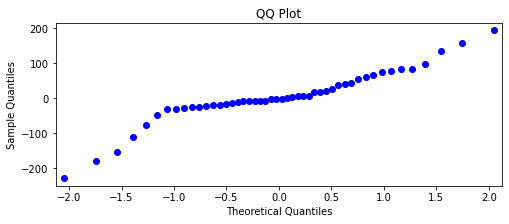

In [95]:
X = df_PN['VALUE-Tx']

# Walk forward validation
history = [x for x in X]
predictions_hw = list()
residuals_hw = list()

for i in range(0, 3):
    model = ExponentialSmoothing(history, trend='add', seasonal='mul', seasonal_periods=12)
    model = model.fit(smoothing_level=0.01, smoothing_slope=0.00002)
    yhat = model.forecast()
    
    predictions_hw.append(yhat)
    history.append(yhat)
#     print('Predicted=%.3f' %(yhat))

pred_temp = list(inv_boxcox(predictions_hw,lamda))

dates = pd.Series(['2018-02-01','2018-03-01', '2018-04-01'])
predictions_hw = pd.DataFrame({'Date':dates, 'VALUE':predictions_hw})
predictions_hw['Date'] = pd.to_datetime(predictions_hw['Date'])
predictions_hw = predictions_hw.set_index('Date')

predictions_PN = pd.DataFrame({'Date':dates, 'State':'Punjab', 'VALUE':pred_temp})
predictions_PN.VALUE = predictions_PN.VALUE.apply(float)

predictions_final = predictions_final.append(predictions_PN)

residuals_hw = model.resid
print('Residual Mean = %.3f' %residuals_hw.mean())

plt.figure(figsize=(10,4))
plt.plot(X, color='blue')
plt.plot(predictions_hw, color='red')
plt.title('Line Plot')

plt.figure(figsize=(10,4))
plt.plot(residuals_hw)
plt.title('Residual Plot')

plt.figure(figsize=(8,3))
rcParams['figure.figsize']=8,3
fig = qqplot(residuals_hw)
plt.title('QQ Plot')
plt.show()


In [96]:
predictions_final.tail(30)

,Date,State,VALUE
0,2018-02-01,Uttar Pradesh,5.190230e+05
1,2018-03-01,Uttar Pradesh,1.407193e+06
2,2018-04-01,Uttar Pradesh,1.378134e+05
0,2018-02-01,Haryana,1.220380e+05
1,2018-03-01,Haryana,1.307519e+05
2,2018-04-01,Haryana,4.021136e+04
0,2018-02-01,Himachal Pradesh,1.229372e+04
1,2018-03-01,Himachal Pradesh,1.353829e+04
2,2018-04-01,Himachal Pradesh,1.245728e+04
0,2018-02-01,Uttarakhand,3.764495e+04


In [97]:
predictions_final['Date'] = pd.to_datetime(predictions_final['Date'])

Text(0.5, 1.0, 'Sales Trend - Himachal Pradesh')

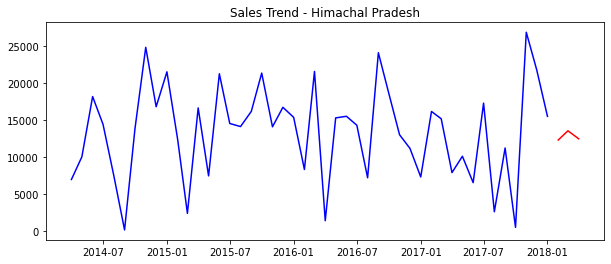

In [98]:
X = df_HP['VALUE']
y = predictions_final[predictions_final['State']=='Himachal Pradesh']
y = y.set_index('Date')['VALUE']

plt.figure(figsize=(10,4))
plt.plot(X, color='blue')
plt.plot(y, color='red')
plt.title('Sales Trend - Himachal Pradesh')

Text(0.5, 1.0, 'Sales Trend - Uttar Pradesh')

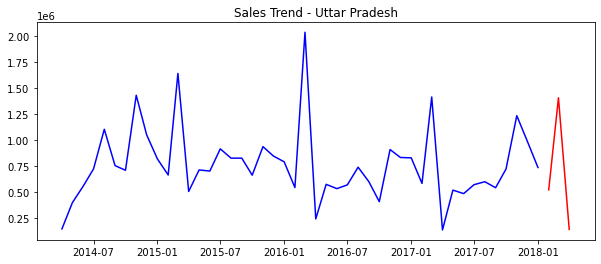

In [99]:
X = df_UP['VALUE']
y = predictions_final[predictions_final['State']=='Uttar Pradesh']
y = y.set_index('Date')['VALUE']

plt.figure(figsize=(10,4))
plt.plot(X, color='blue')
plt.plot(y, color='red')
plt.title('Sales Trend - Uttar Pradesh')

Text(0.5, 1.0, 'Sales Trend - Haryana')

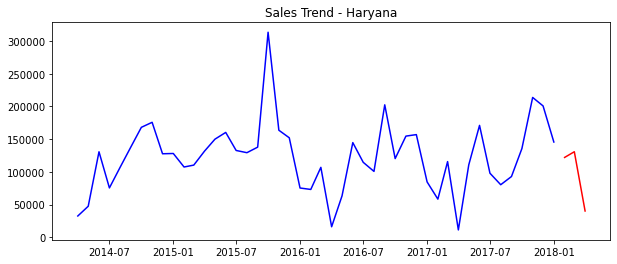

In [100]:
X = df_HR['VALUE']
y = predictions_final[predictions_final['State']=='Haryana']
y = y.set_index('Date')['VALUE']

plt.figure(figsize=(10,4))
plt.plot(X, color='blue')
plt.plot(y, color='red')
plt.title('Sales Trend - Haryana')

Text(0.5, 1.0, 'Sales Trend - Uttarakhand')

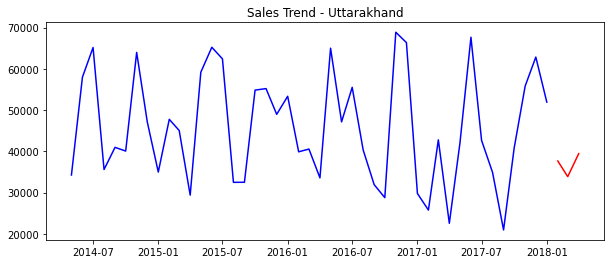

In [101]:
X = df_UT['VALUE']
y = predictions_final[predictions_final['State']=='Uttarakhand']
y = y.set_index('Date')['VALUE']

plt.figure(figsize=(10,4))
plt.plot(X, color='blue')
plt.plot(y, color='red')
plt.title('Sales Trend - Uttarakhand')

Text(0.5, 1.0, 'Sales Trend - Punjab')

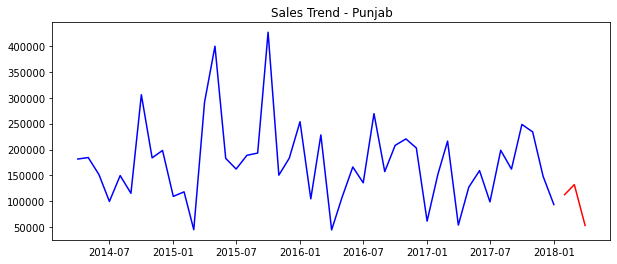

In [102]:
X = df_PN['VALUE']
y = predictions_final[predictions_final['State']=='Punjab']
y = y.set_index('Date')['VALUE']

plt.figure(figsize=(10,4))
plt.plot(X, color='blue')
plt.plot(y, color='red')
plt.title('Sales Trend - Punjab')

In [103]:
predictions_final

,Date,State,VALUE
0,2018-02-01,Uttar Pradesh,5.190230e+05
1,2018-03-01,Uttar Pradesh,1.407193e+06
2,2018-04-01,Uttar Pradesh,1.378134e+05
0,2018-02-01,Haryana,1.220380e+05
1,2018-03-01,Haryana,1.307519e+05
2,2018-04-01,Haryana,4.021136e+04
0,2018-02-01,Himachal Pradesh,1.229372e+04
1,2018-03-01,Himachal Pradesh,1.353829e+04
2,2018-04-01,Himachal Pradesh,1.245728e+04
0,2018-02-01,Uttarakhand,3.764495e+04


In [105]:
predictions_final.to_csv('Sales-prediction-final.csv')